In [1]:
BASE_PATH = "/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/"

from sys import path

path.append(f"{BASE_PATH}Scripts/")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import makedirs

from datetime import datetime, timedelta
import PyEMD
from EMDComparison.signalHelpers import Signal, SignalFunctions, compareTS, new_plot_format
from astropy.convolution import Box1DKernel, convolve
from sunpy.time import parse_time
import idlsave


In [2]:
# Set the unsafe, target safe, and dataFolder
unsafe_dir = "/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/"
saveFolder = f"{unsafe_dir}ISSI/"
dataFolder = f"/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/ISSI/data/"

# Parameters for DELETION, showing FIG
DELETE = False
SHOWFIG = True

# We set a large possible set of periodicities
PeriodMinMax = [5, 20]
makedirs(saveFolder, exist_ok=True)

# IN SITU DATA
df_is = pd.read_csv(f"{dataFolder}small_ch_in_situ.csv")
df_is.index = pd.to_datetime(df_is["Time"])
del df_is["Time"]

insituParams = ["Vr", "Mf", "Np", "T", "Br"]
df_is = df_is[insituParams]

# REMOTE DATA
rs_171 = idlsave.read(f'{dataFolder}small_ch_171_lc_in.sav', verbose=False)
rs_193 = idlsave.read(f'{dataFolder}small_ch_193_lc_in.sav', verbose=False)
ch_flux = idlsave.read(f'{dataFolder}chflux.sav', verbose=False)

# 171 and 193 observations
time_array = rs_171.date_obs_171.copy()
time_array = [t.decode() for t in list(time_array)]

df_171 = pd.DataFrame(
    {
        'plume': rs_171.lc_171_plume_in,
        'cbpoint': rs_171.lc_171_bp_in,
        'chplume': rs_171.lc_171_ch_plume_in,
        'chole': rs_171.lc_171_ch_in,
        'qsun': rs_171.lc_171_qs_in,
    },
    index=pd.to_datetime(time_array))

df_193 = pd.DataFrame(
    {
        'plume': rs_193.lc_193_plume_in,
        'cbpoint': rs_193.lc_193_bp_in,
        'chplume': rs_193.lc_193_ch_plume_in,
        'chole': rs_193.lc_193_ch_in,
        'qsun': rs_193.lc_193_qs_in,
    },
    index=pd.to_datetime(time_array))

# Open and Bright point flux
flux_time = ch_flux.hmitimes.copy()
flux_time = [t.decode() for t in list(flux_time)]

df_flux = pd.DataFrame(
    {
        "ch_open_flux": ch_flux.chofluxes,
        "ch_bpoint_flux": ch_flux.chbpfluxes,
    },
    index=pd.to_datetime(flux_time, format="%Y.%m.%d_%H:%M:%S_TAI"))

# Using compareTS from signalFunctions

In [3]:
def AIA_compare(
                AIA=None, 
                PSP=None,
                subfolderInfo="171",
                AIA_id="171",
                PeriodMinMax=[5, 20],
                delete=True,
                showFig=True,
                highlightRegion=False,
                showSpeed=True,
                LOSPEED = 0,
                HISPEED = 0,
                ):
    """
    AIA = Should be AIA / HMI df
    PSP = Should be cut down is_df
    subfolderInfo tells us about both remote and IS, hopefully
    AIA_id carries information about remote observation selected
    """
    AIA.columns = [f"{AIA_id}_{i}" for i in AIA.columns]
    PSP.columns = [f"PSP_{i}" for i in PSP.columns]
    specificFolder = f"{saveFolder}{subfolderInfo}/"
    compareTS(
        dfSelf=AIA,
        dfOther=PSP,
        cadSelf=60,
        cadOther=60,
        labelOther="PSP",
        winDispList=[60],
        corrThrPlotList=np.arange(0.65, 1, 0.05),
        PeriodMinMax=PeriodMinMax,
        filterPeriods=True,
        savePath=specificFolder,
        useRealTime=True,
        expectedLocationList=highlightRegion,
        detrend_box_width=200,
        delete=delete,
        showFig=showFig,
        renormalize=False,
        showSpeed=True,
        HISPEED=HISPEED,
        LOSPEED=LOSPEED,
        SPCKernelName="psp")

# Test case 1: 10-hours of in situ versus all remote

In [4]:
# # Selecting ~ 10 hours of in situ observations with 14 switchbacks
# timeInsitu = (datetime(2018, 10, 31, 12), datetime(2018, 10, 31, 22))
# df_is_copy = df_is[timeInsitu[0]:timeInsitu[1]].copy()

# timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))
# df_171_sb_6789 = df_171[timeSbs[0]:timeSbs[1]] 
# df_193_sb_6789 = df_193[timeSbs[0]:timeSbs[1]] 

# highlightRegion =  [{
#                     "start": datetime(2018,10,31,16),
#                     "end": datetime(2018,10,31,20),
#                     "color": "blue",
#                     "label": "SB bmap.",
#                     }, ]

# for remDF, remLabel in zip((df_171_sb_6789, df_193_sb_6789), ("171", "193")):
#     AIA_compare(
#         AIA=remDF.copy(), PSP=df_is_copy.copy(), AIA_id=remLabel, 
#         PeriodMinMax = PeriodMinMax, delete=DELETE, showFig=SHOWFIG,
#         subfolderInfo="SB_6789", showSpeed=True, 
#         highlightRegion = highlightRegion,
#         LOSPEED=df_is_copy["Vr"].min(), HISPEED = df_is_copy["Vr"].max()
#         )

In [5]:
# Selecting ~ 10 hours of in situ observations with 14 switchbacks
timeInsitu = (datetime(2018, 10, 31, 12), datetime(2018, 10, 31, 22))
df_is_cut = df_is[timeInsitu[0]:timeInsitu[1]].copy()

# Time in situ is one hour only?
timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))
df_171_cut = df_171[timeSbs[0]:timeSbs[1]] 
df_193_cut = df_193[timeSbs[0]:timeSbs[1]] 

lcDic = {
    "171": df_171_cut.interpolate(),
    "193": df_193_cut.interpolate(),
}

In [6]:
def AIA_newplot(
                lcDic=None, 
                dfPSP=None,
                base_folder=None,
                PeriodMinMax=[5, 20],
                showSpeed=True,
                spcSpeeds = (None, None)
                ):

                new_plot_format(
                    dfInsitu=dfPSP,
                    lcDic=lcDic,
                    regions=regions,
                    base_folder=base_folder,
                    period=PeriodMinMax,
                    addResidual = False,
                    addEMDLcurves = True,
                    SPCKernelName = "psp",
                    spcSpeeds=spcSpeeds,
                )

regions = ["chole", "cbpoint", "plume", "qsun", "chplume"]
pspLO, pspHI = df_is_cut["Vr"].min(), df_is_cut["Vr"].max()

for dirExtension in ["SB_6789"]:
    # Dictionary with relevant RS data
    AIA_newplot(
        lcDic= lcDic,
        dfPSP= df_is_cut,
        base_folder= f"{saveFolder}{dirExtension}/",
        spcSpeeds= (pspLO, pspHI))
        

['Vr', 'Mf', 'Np', 'T', 'Br']
Region chole
['Vr', 'Mf', 'Np', 'T', 'Br']
Region cbpoint
['Vr', 'Mf', 'Np', 'T', 'Br']
Region plume
['Vr', 'Mf', 'Np', 'T', 'Br']
Region qsun
['Vr', 'Mf', 'Np', 'T', 'Br']
Region chplume


## Second case with less switchbacks

Normalising PSP_Vr
Normalising 171_plume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_plume/PSP_Vr/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


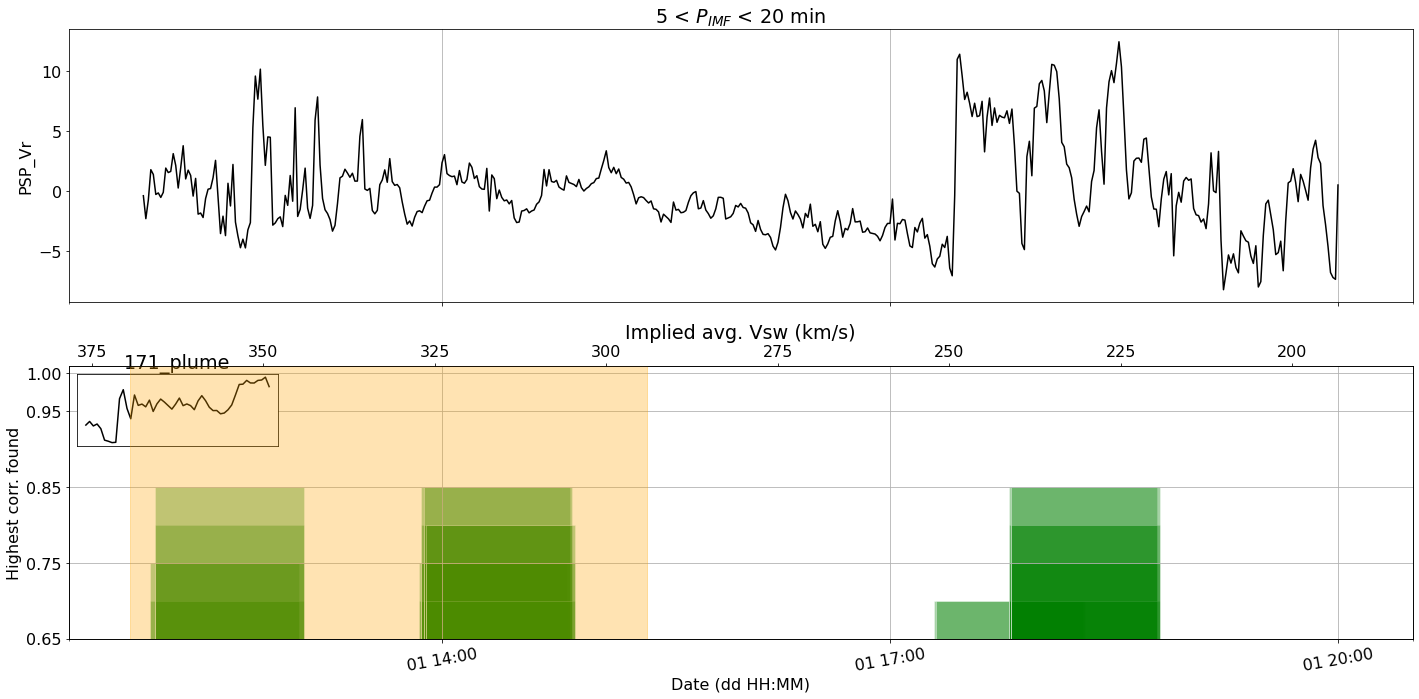

Normalising 171_cbpoint
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_cbpoint/PSP_Vr/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


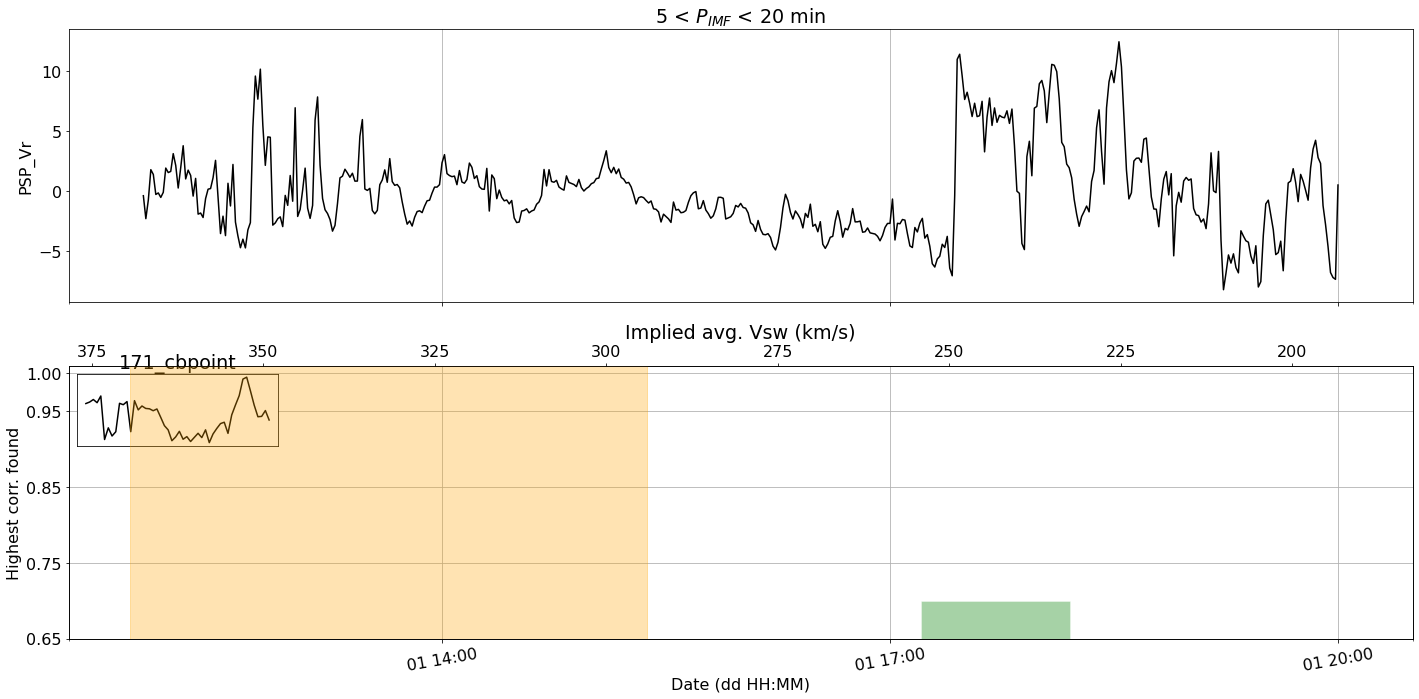

Normalising 171_chplume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_chplume/PSP_Vr/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


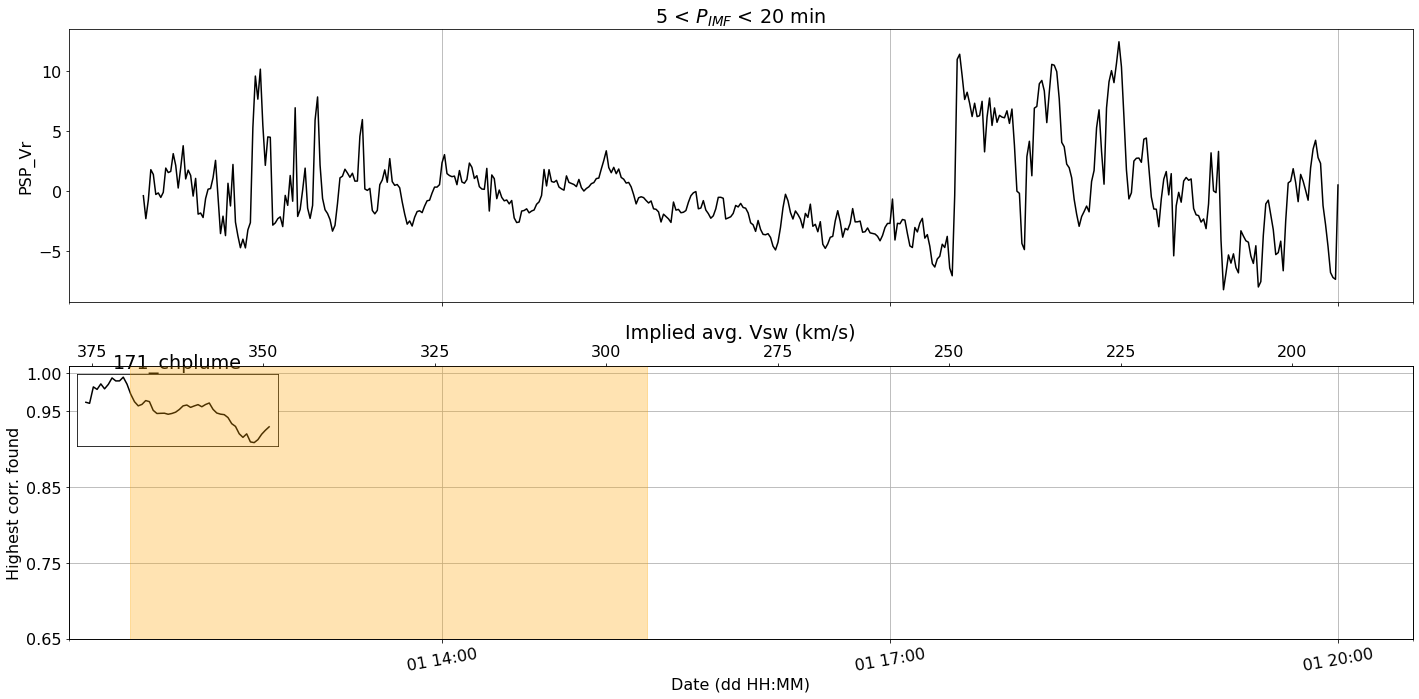

Normalising 171_chole
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_chole/PSP_Vr/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


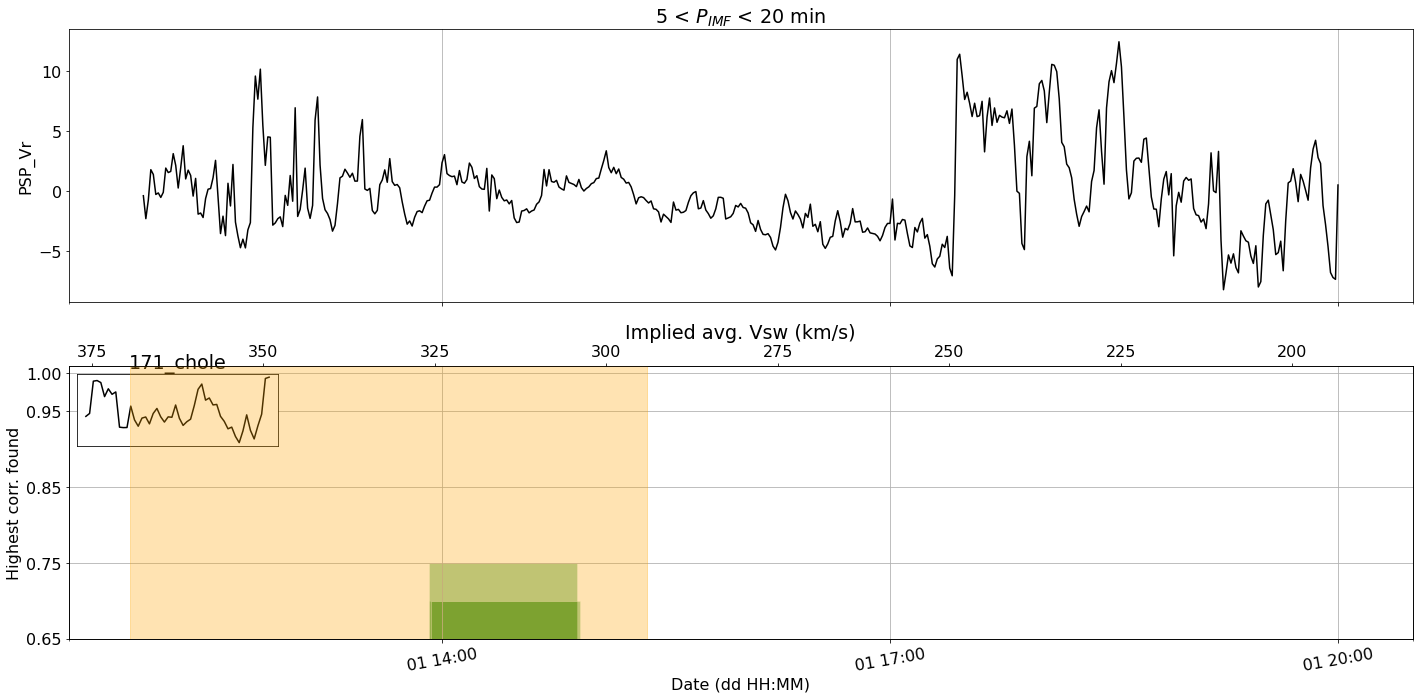

Normalising 171_qsun
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_qsun/PSP_Vr/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


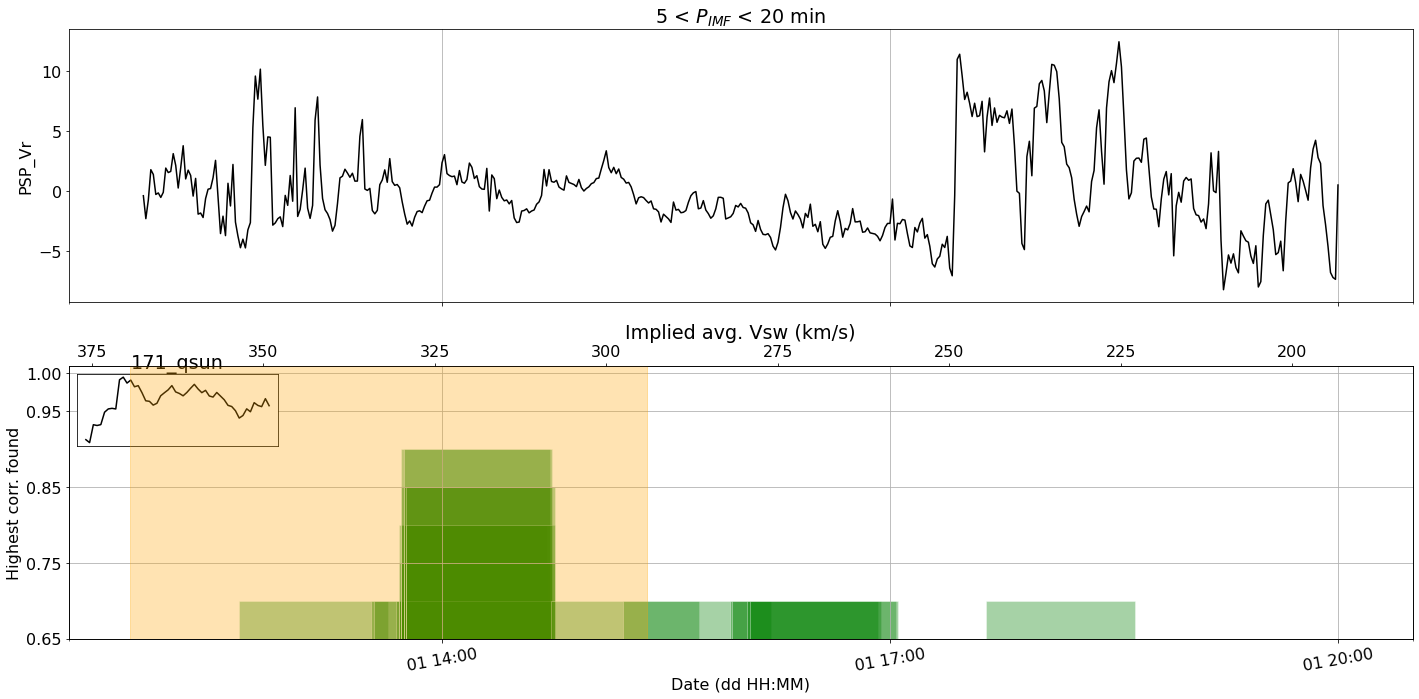

Normalising PSP_Mf
Normalising 171_plume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_plume/PSP_Mf/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


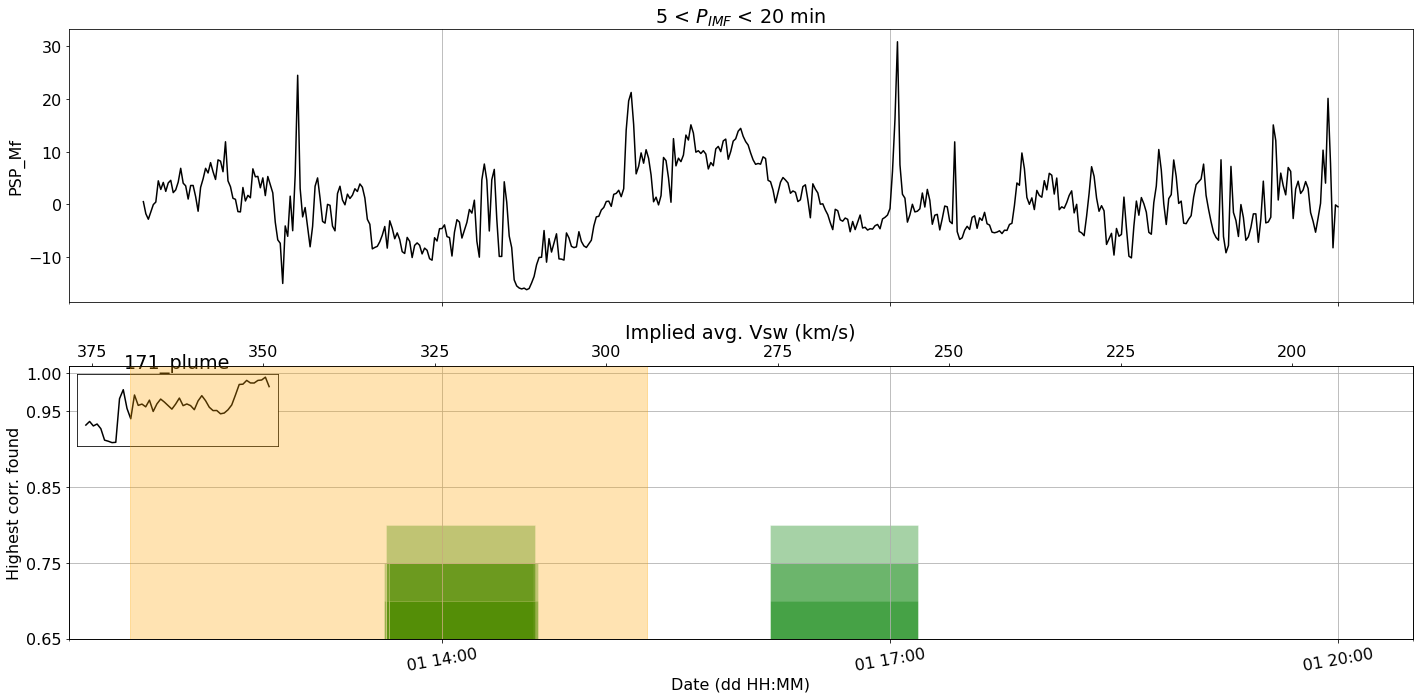

Normalising 171_cbpoint
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_cbpoint/PSP_Mf/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


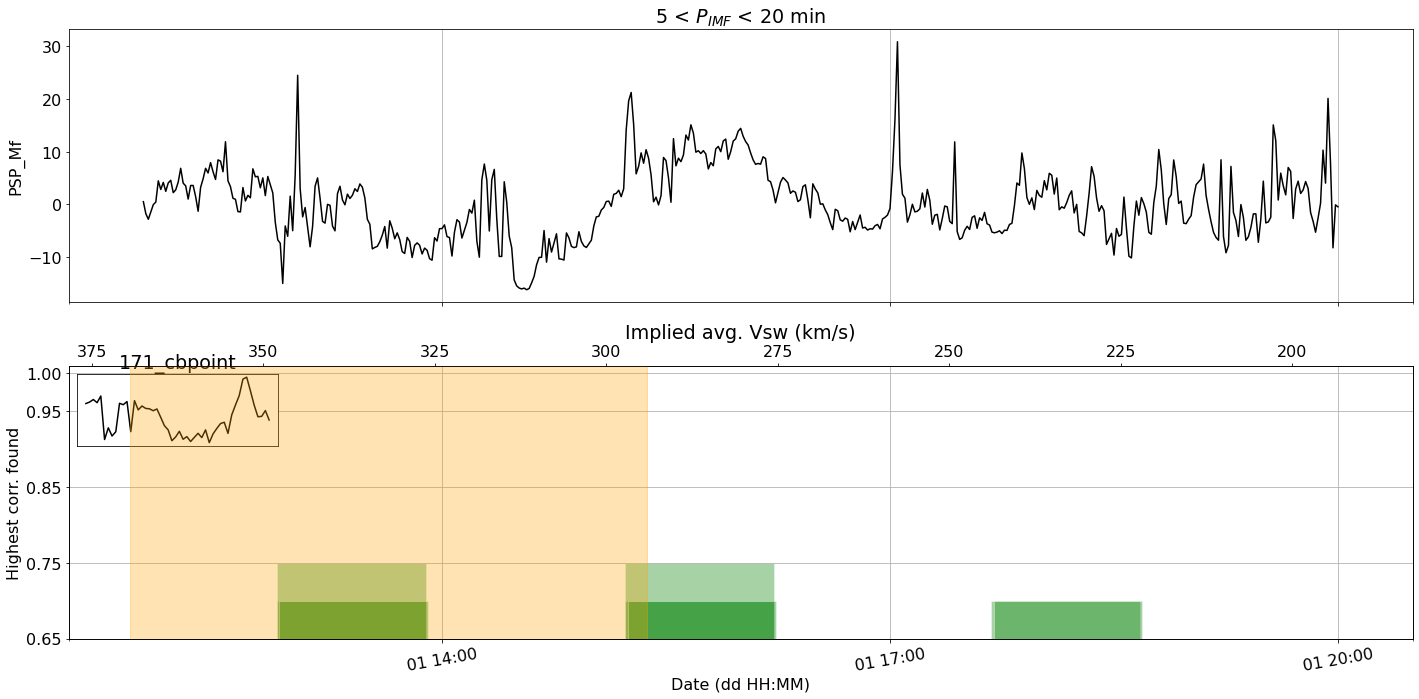

Normalising 171_chplume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_chplume/PSP_Mf/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


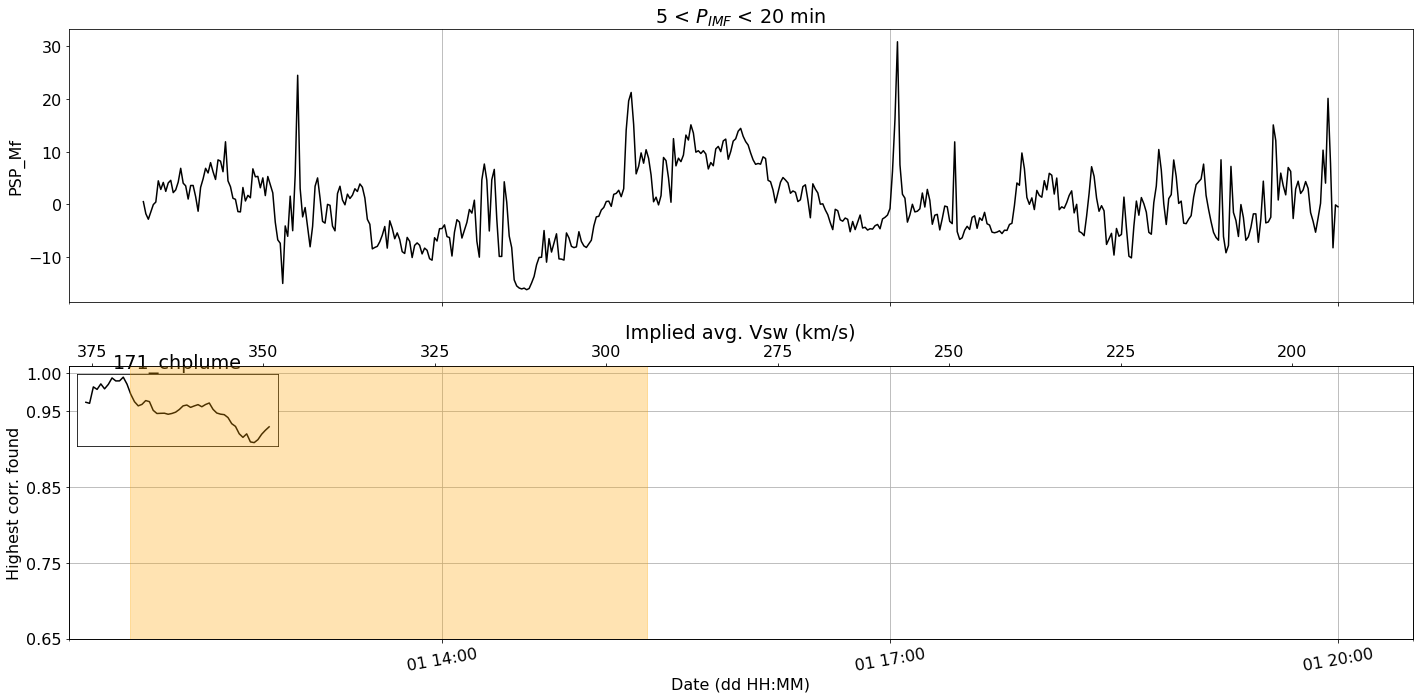

Normalising 171_chole
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_chole/PSP_Mf/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


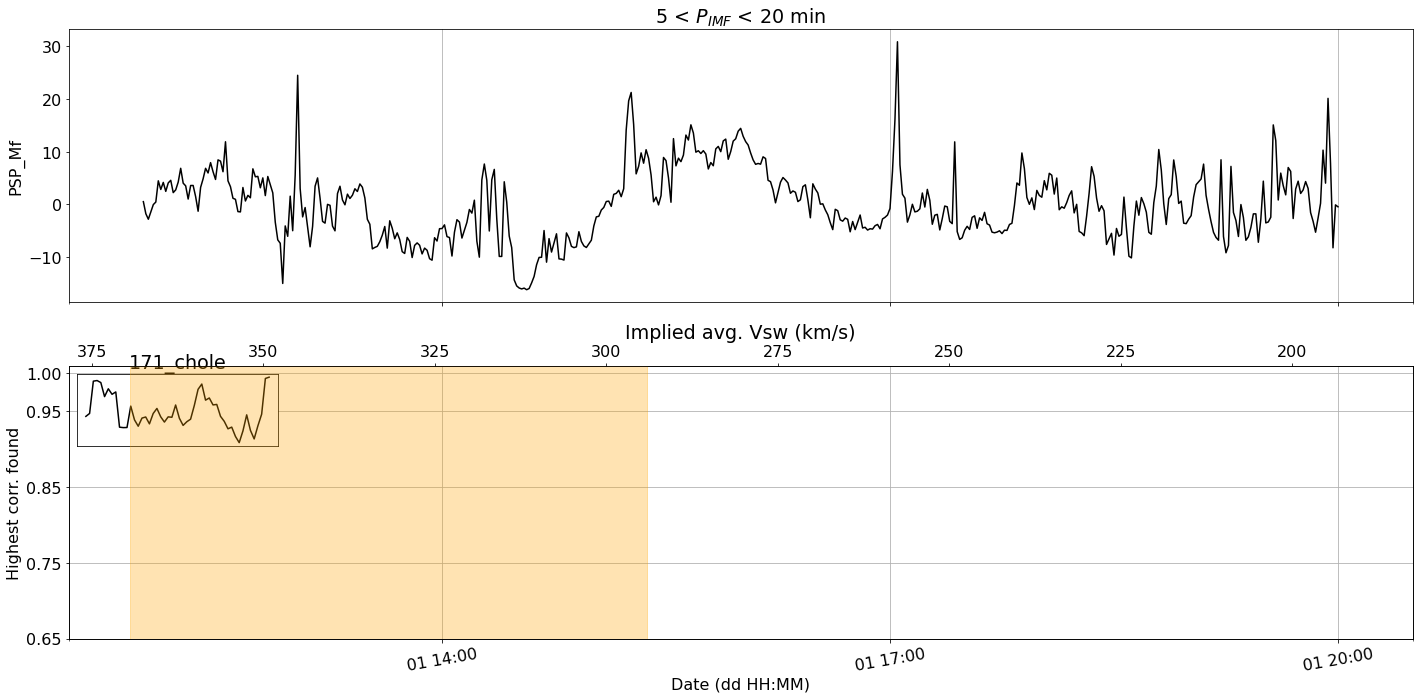

Normalising 171_qsun
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_qsun/PSP_Mf/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


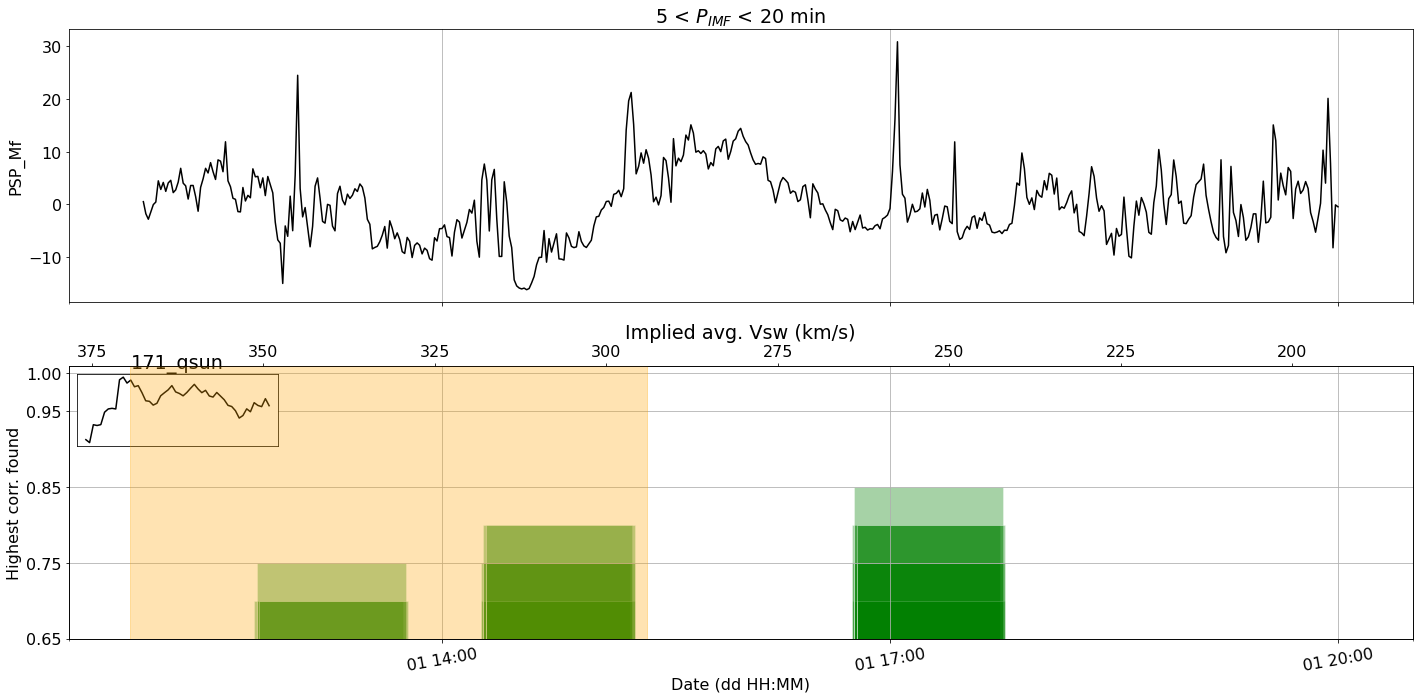

Normalising PSP_Np
Normalising 171_plume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_plume/PSP_Np/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


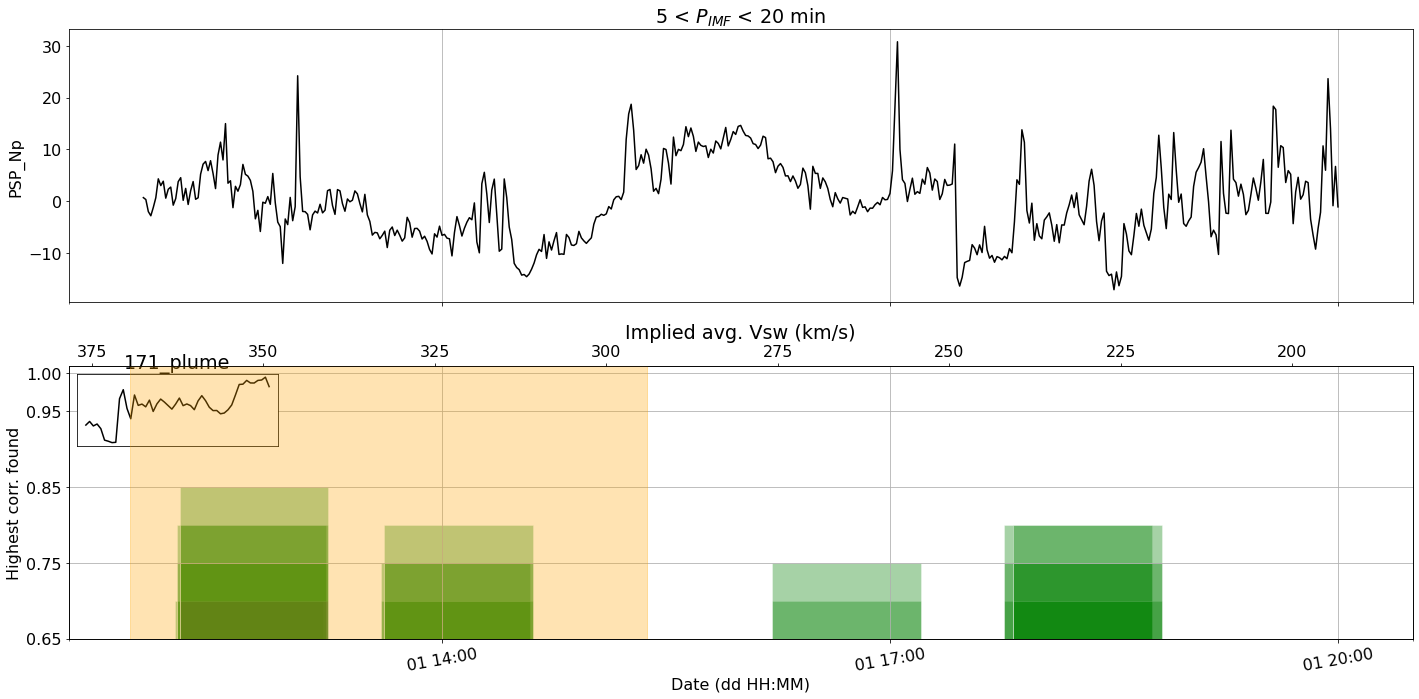

Normalising 171_cbpoint
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_cbpoint/PSP_Np/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


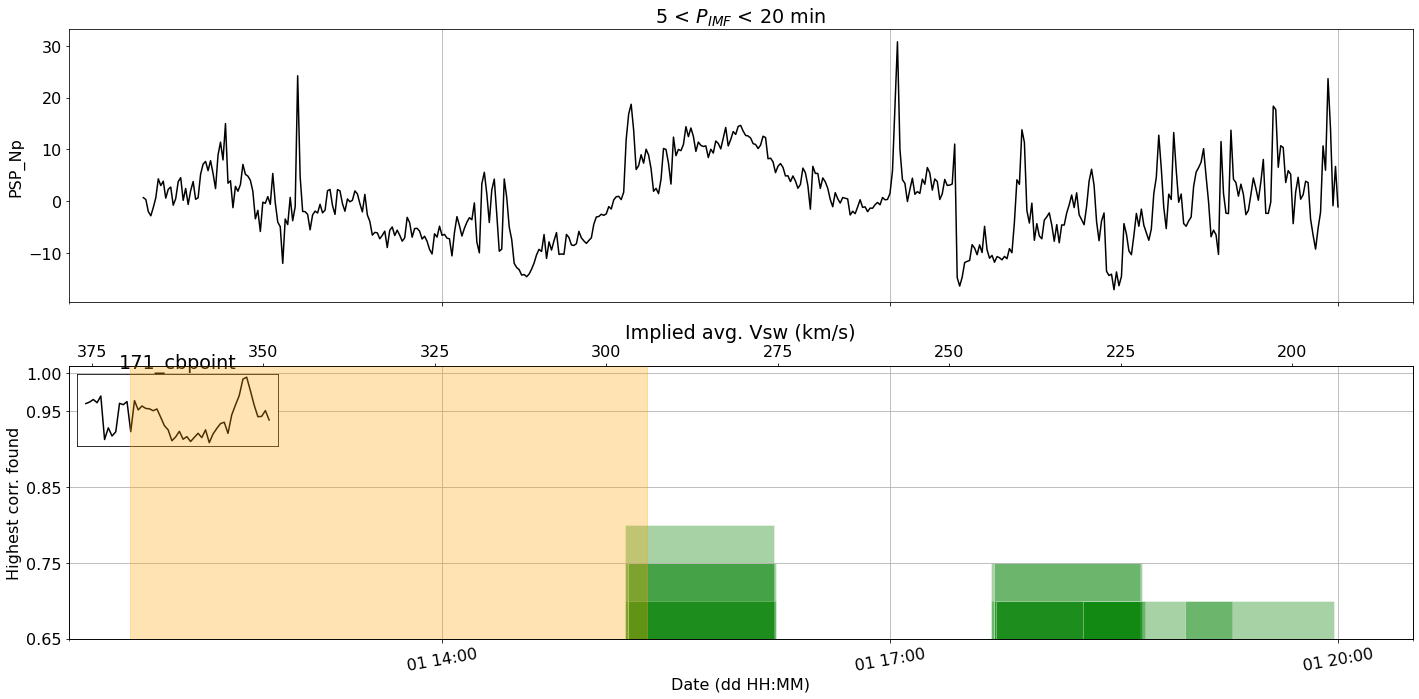

Normalising 171_chplume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_chplume/PSP_Np/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


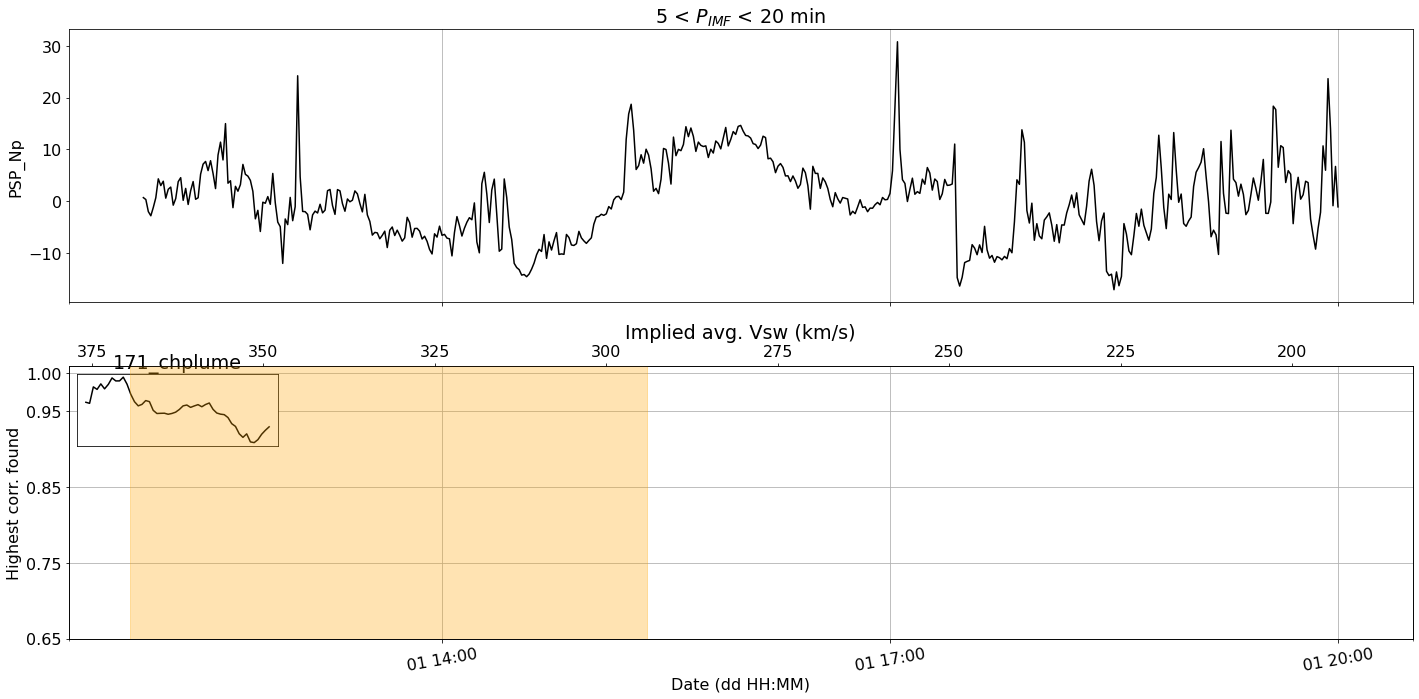

Normalising 171_chole
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_chole/PSP_Np/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


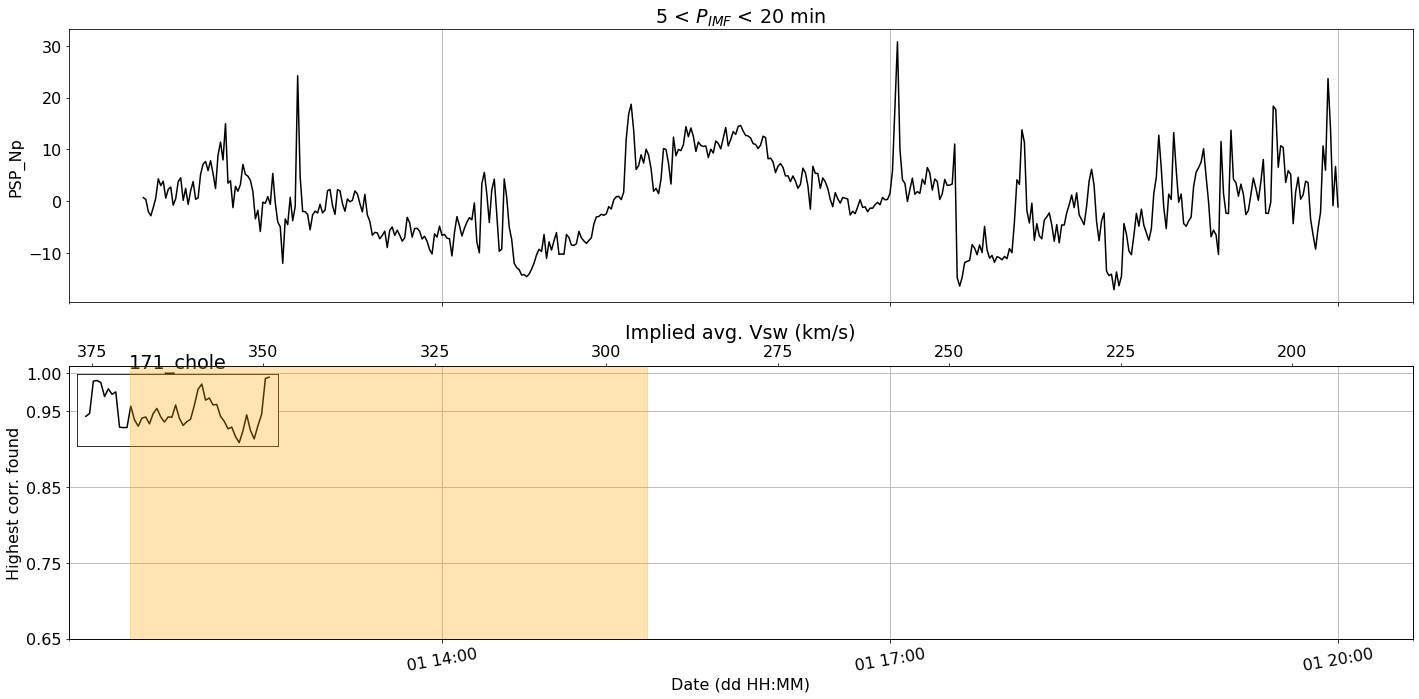

Normalising 171_qsun
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_qsun/PSP_Np/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


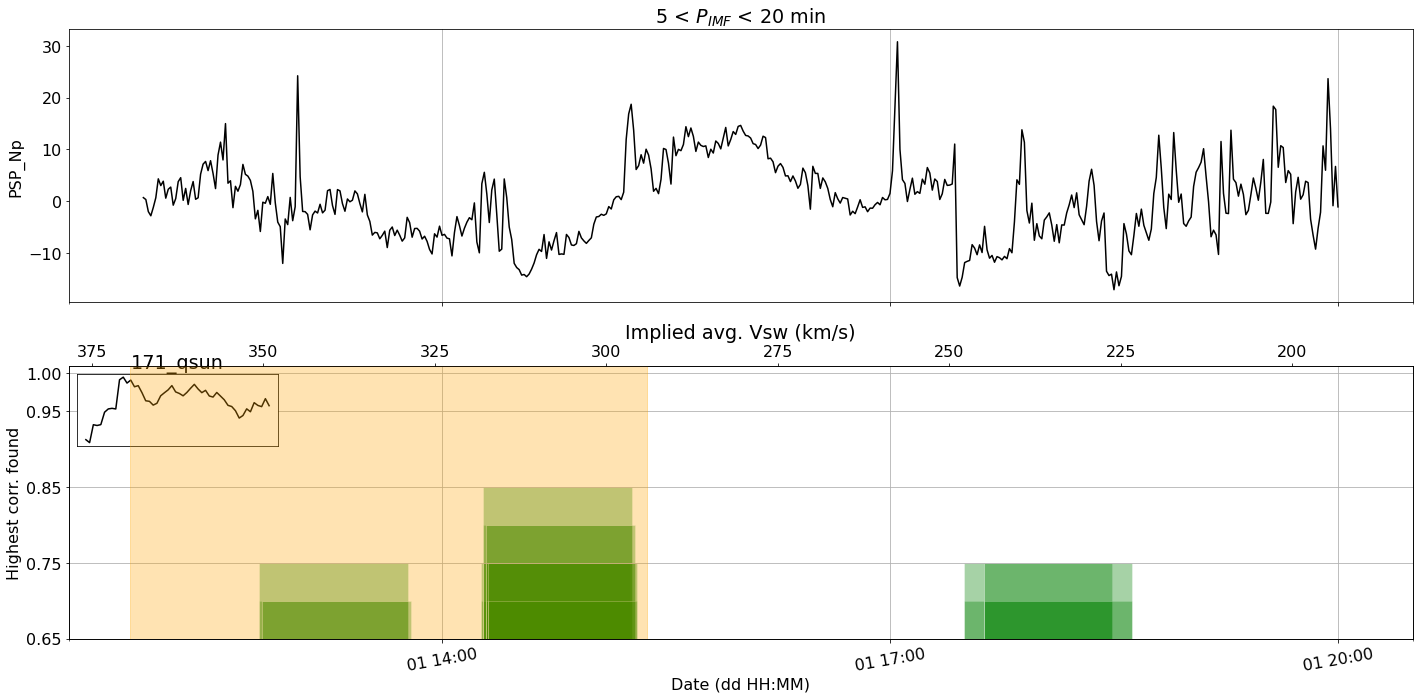

Normalising PSP_T
Normalising 171_plume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_plume/PSP_T/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


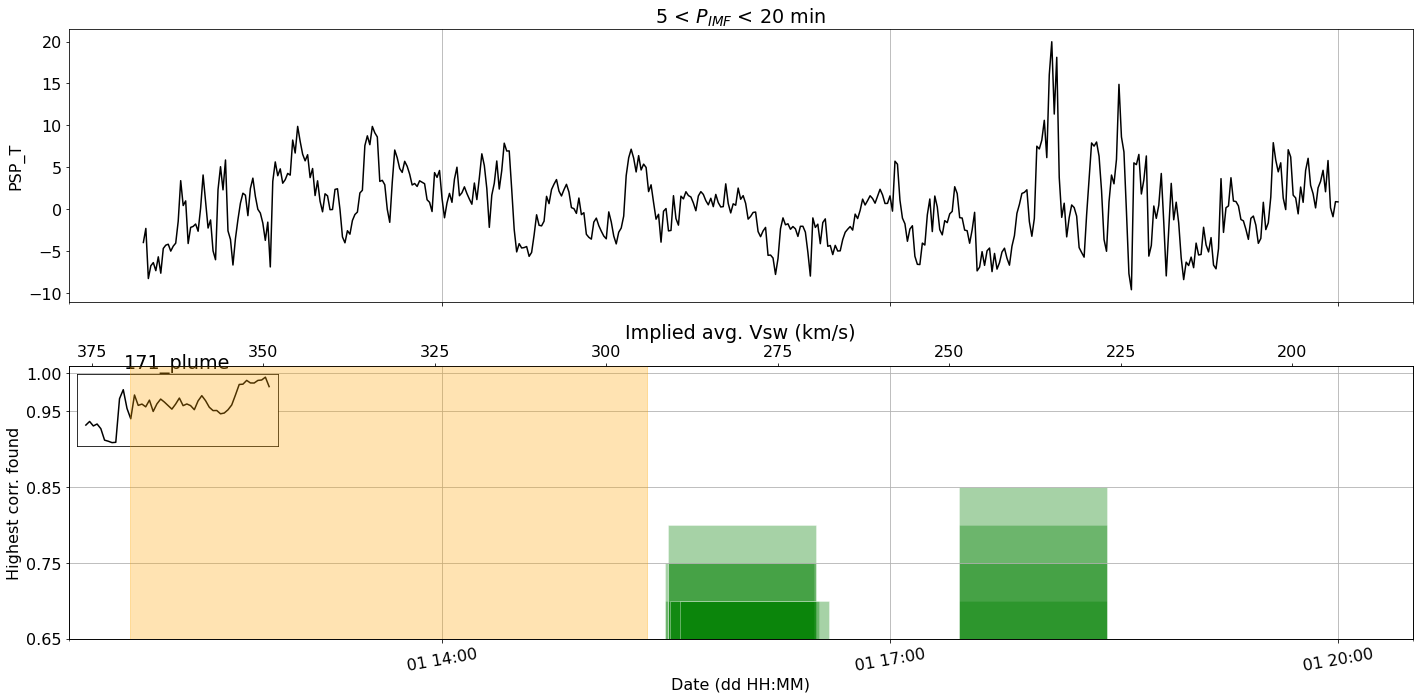

Normalising 171_cbpoint
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_cbpoint/PSP_T/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


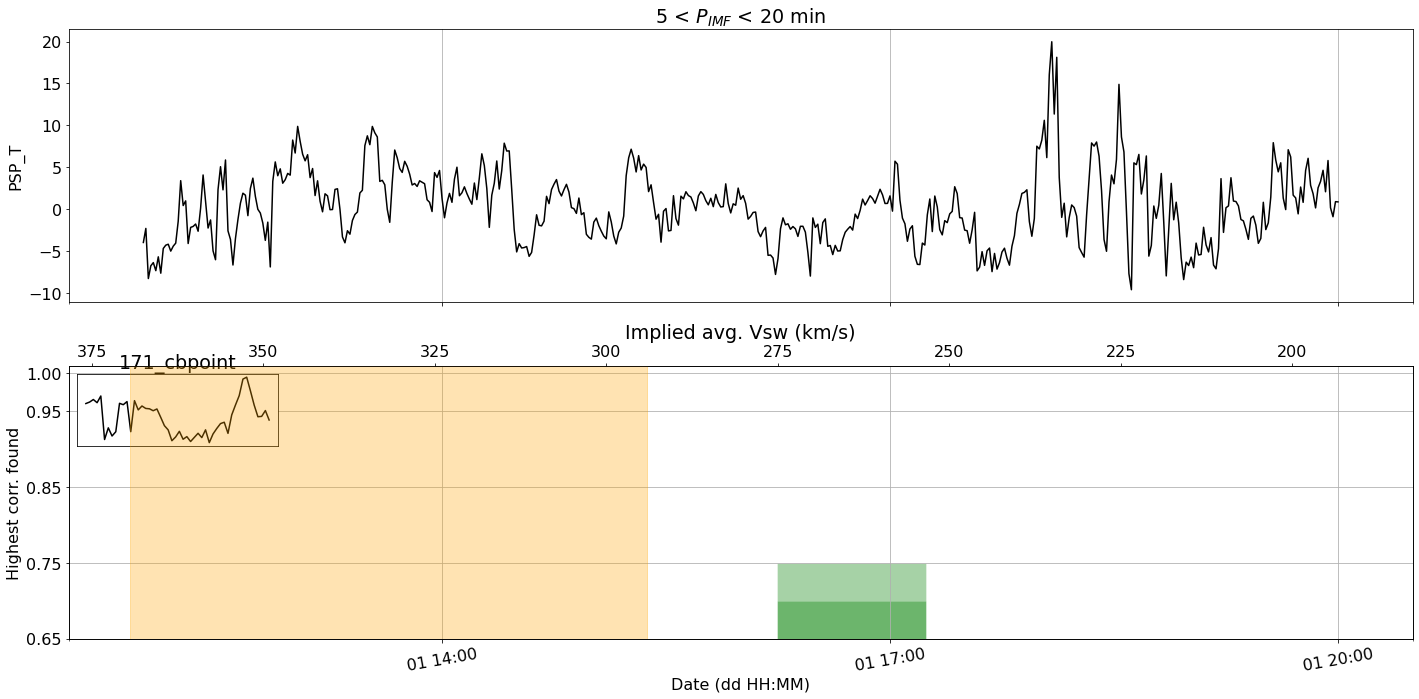

Normalising 171_chplume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_chplume/PSP_T/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


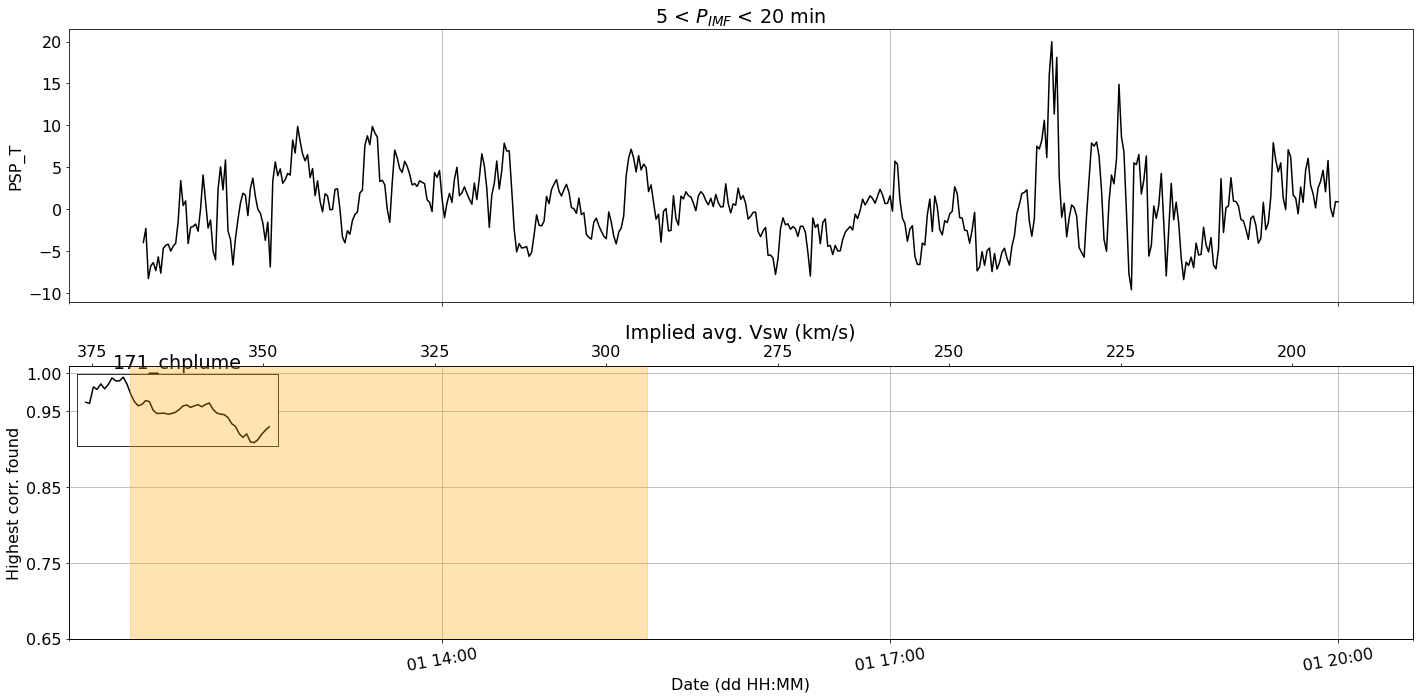

Normalising 171_chole
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_chole/PSP_T/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


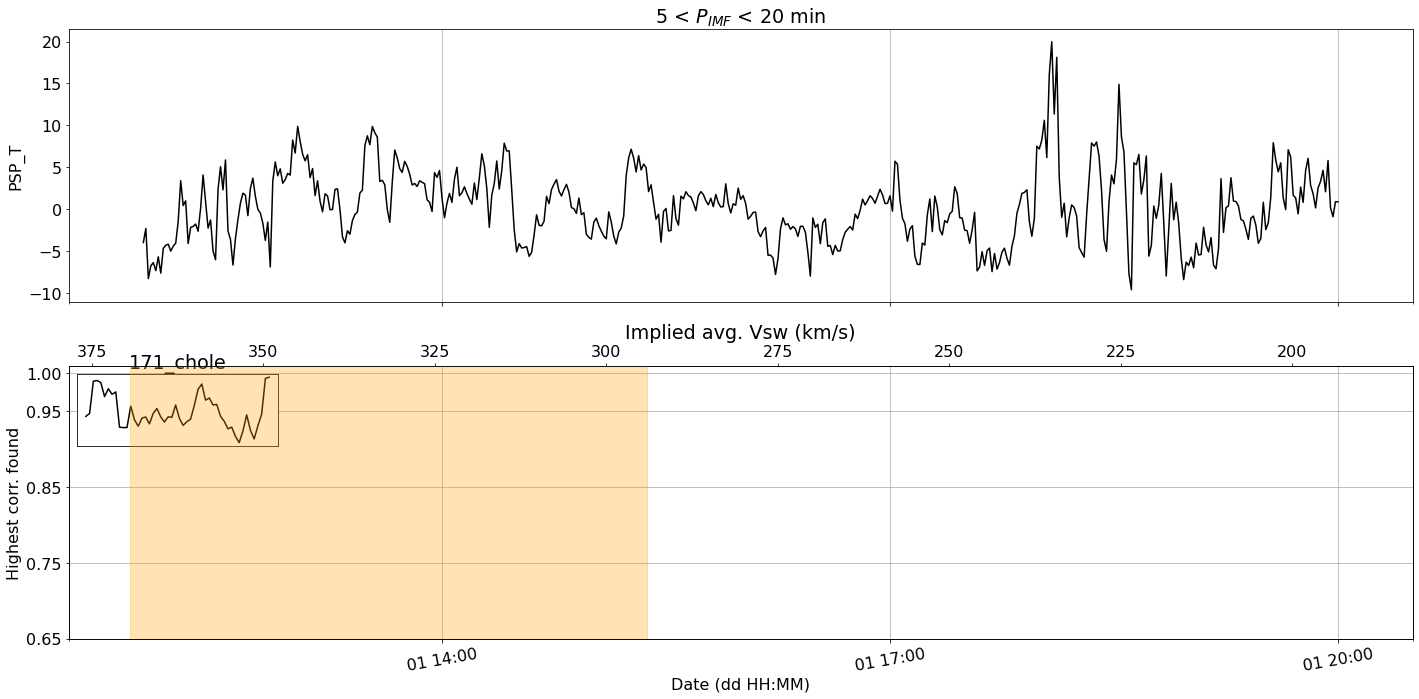

Normalising 171_qsun
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_qsun/PSP_T/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


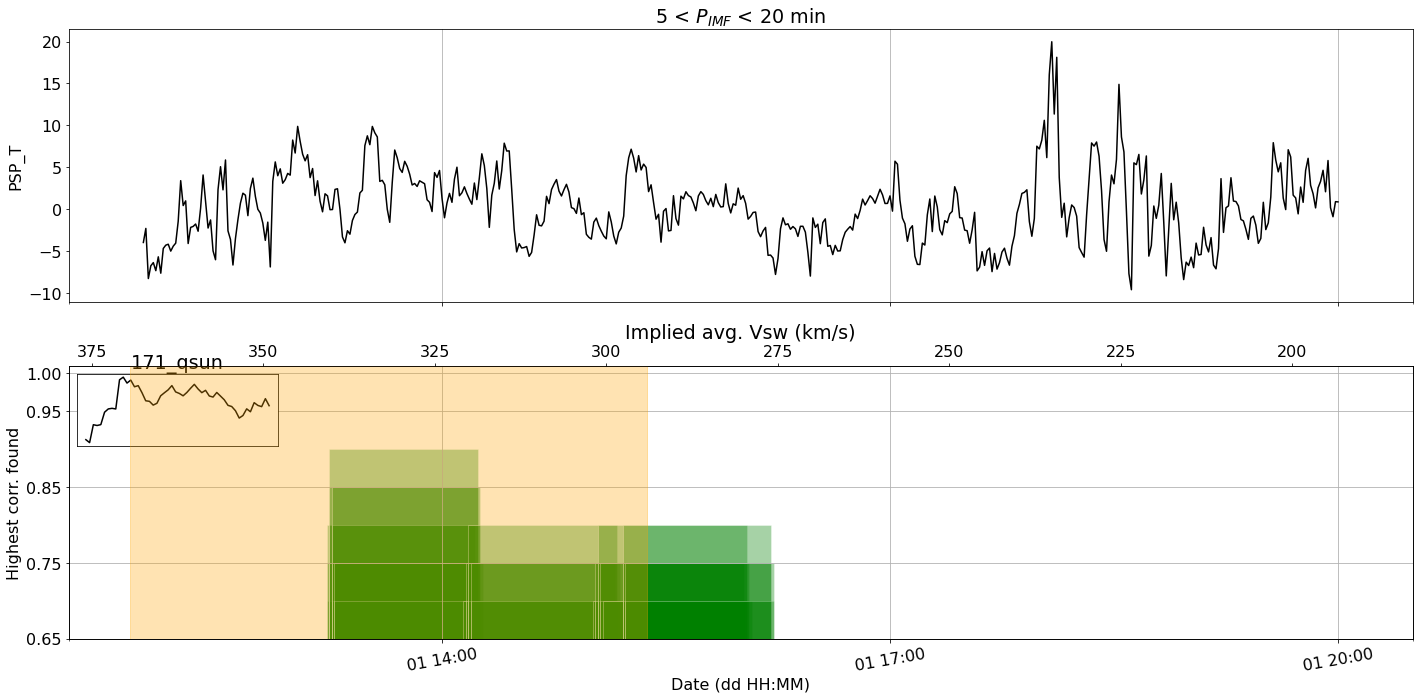

Normalising PSP_Br
Normalising 171_plume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_plume/PSP_Br/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


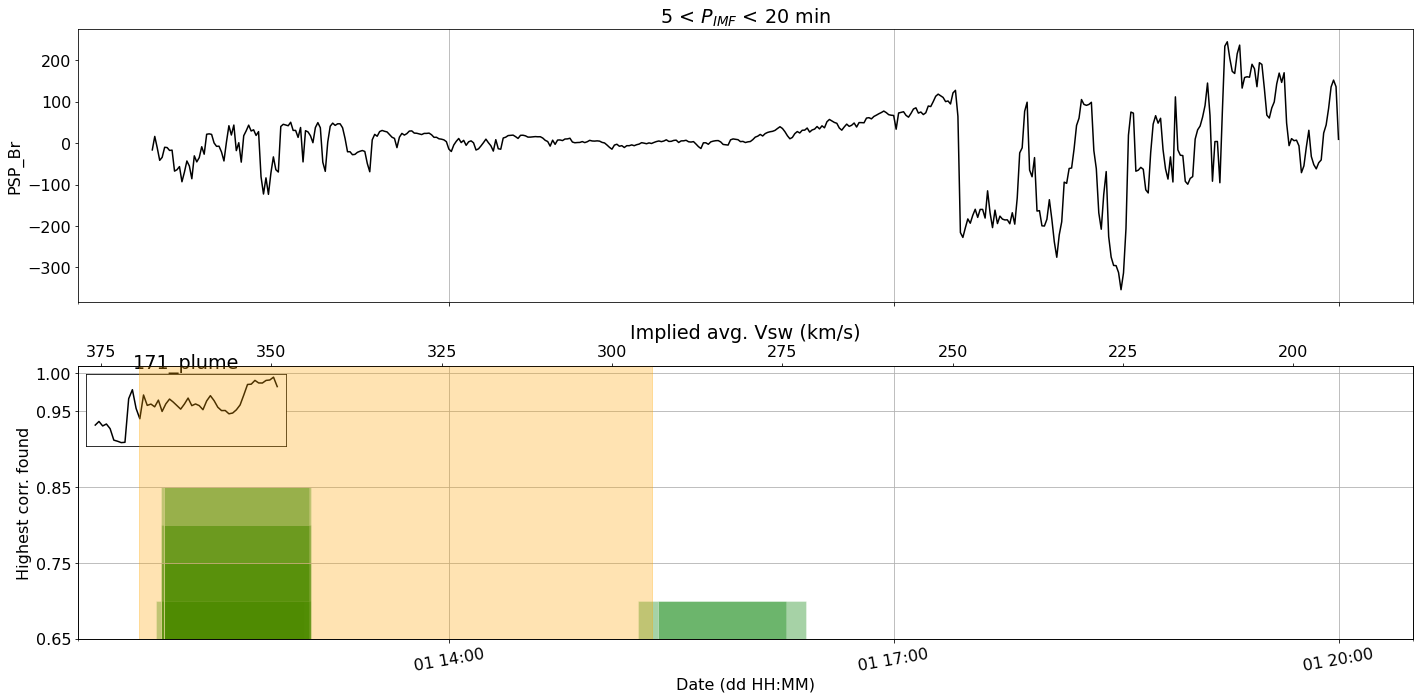

Normalising 171_cbpoint
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_cbpoint/PSP_Br/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


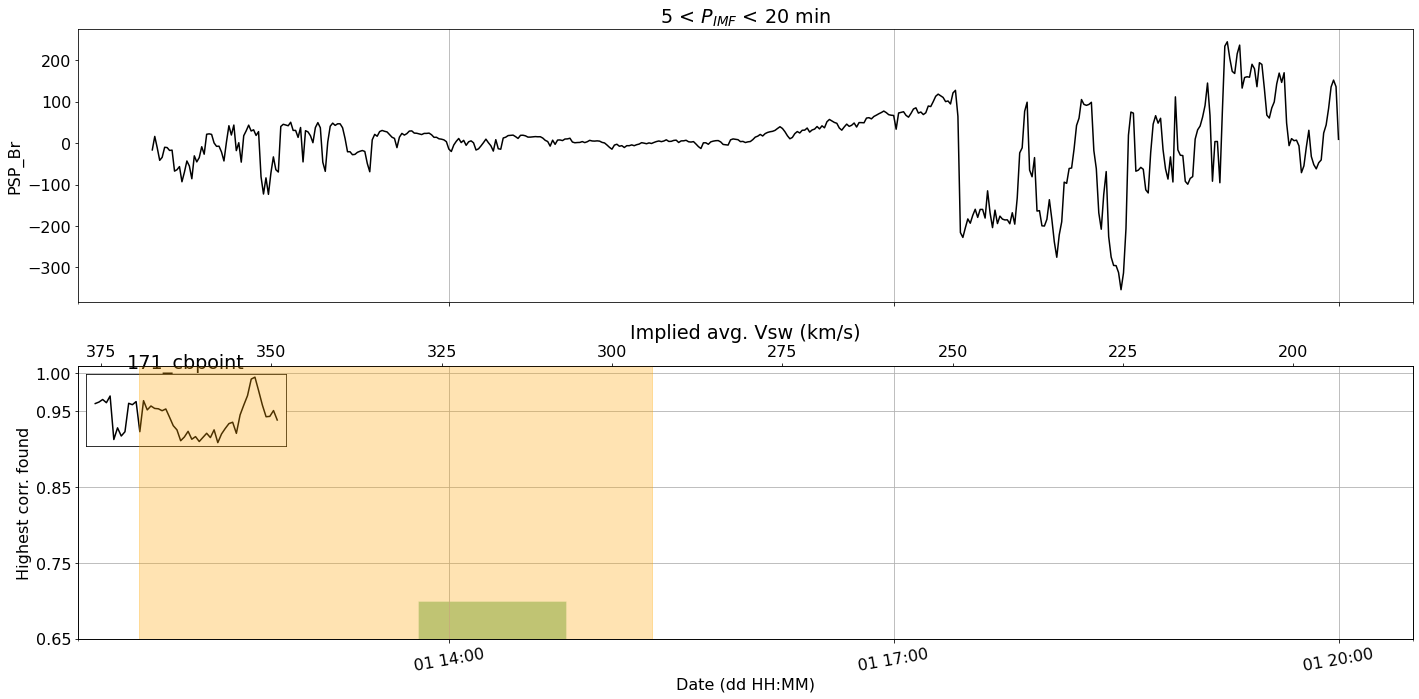

Normalising 171_chplume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_chplume/PSP_Br/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


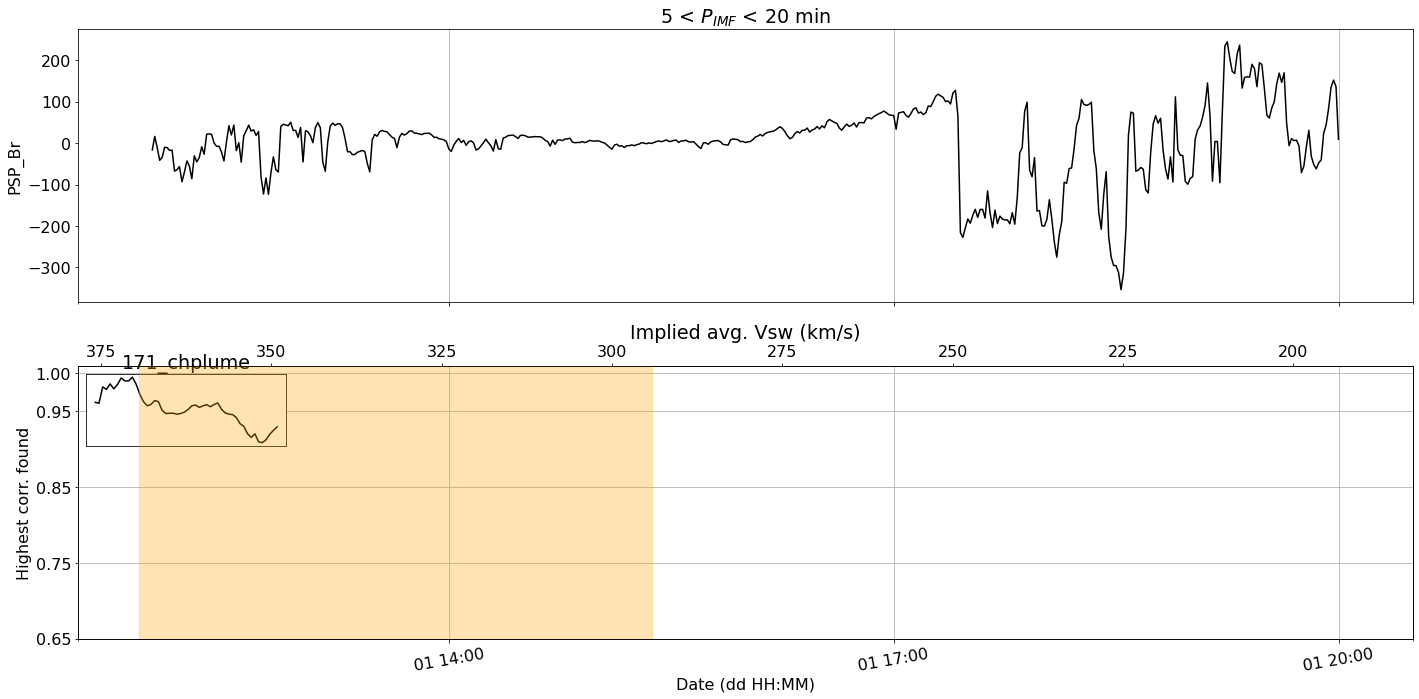

Normalising 171_chole
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_chole/PSP_Br/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


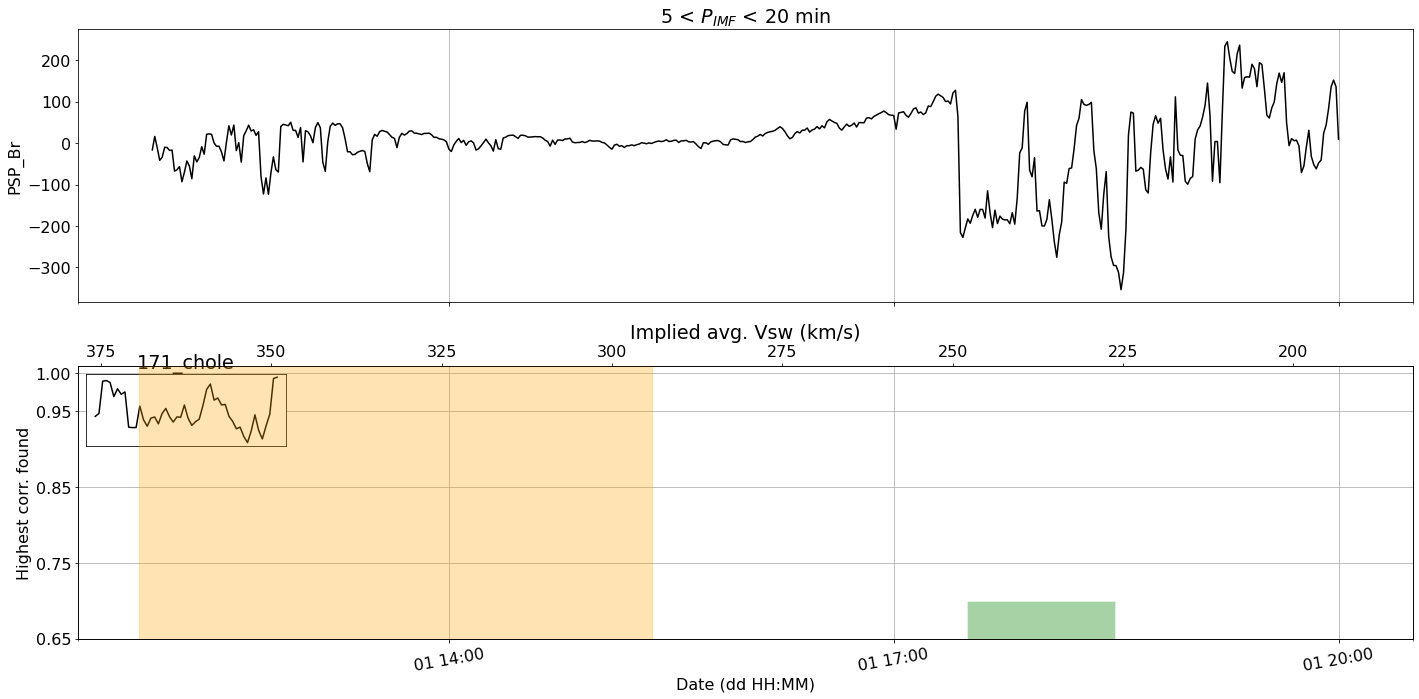

Normalising 171_qsun
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/171_qsun/PSP_Br/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


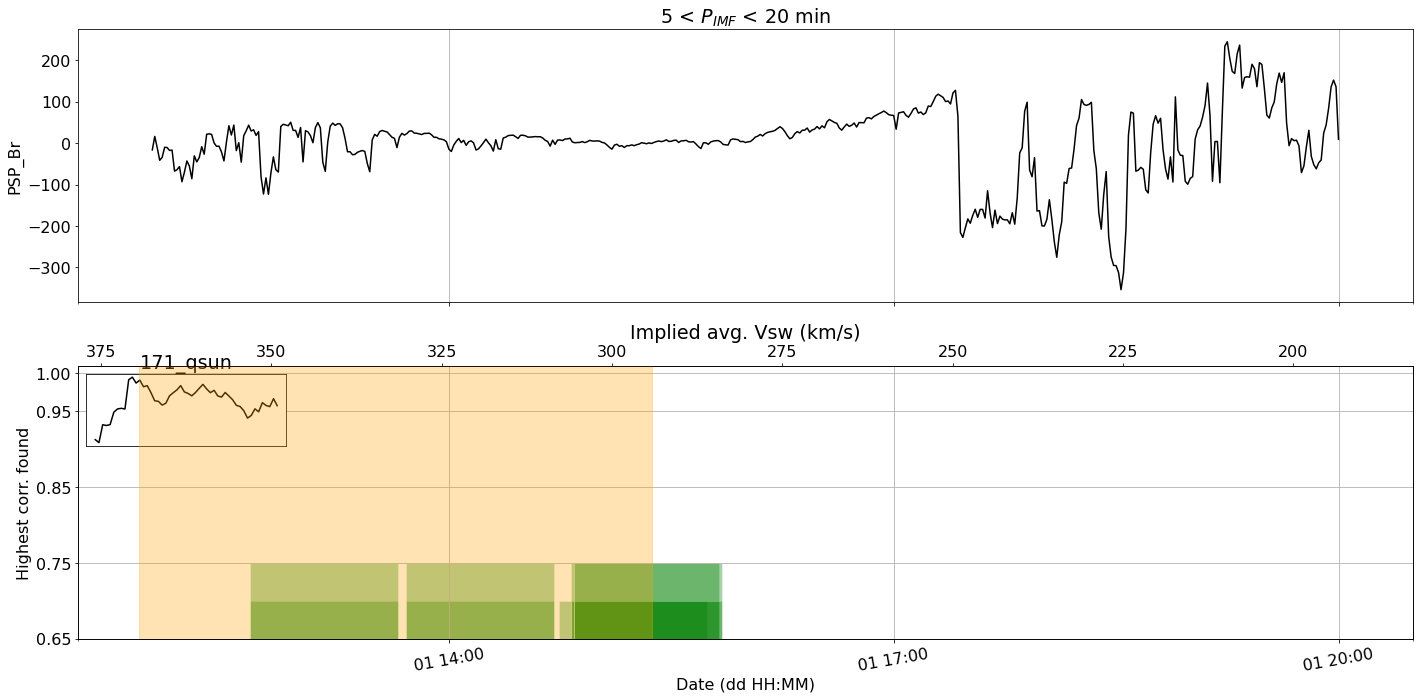

Normalising PSP_Vr
Normalising 193_plume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_plume/PSP_Vr/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


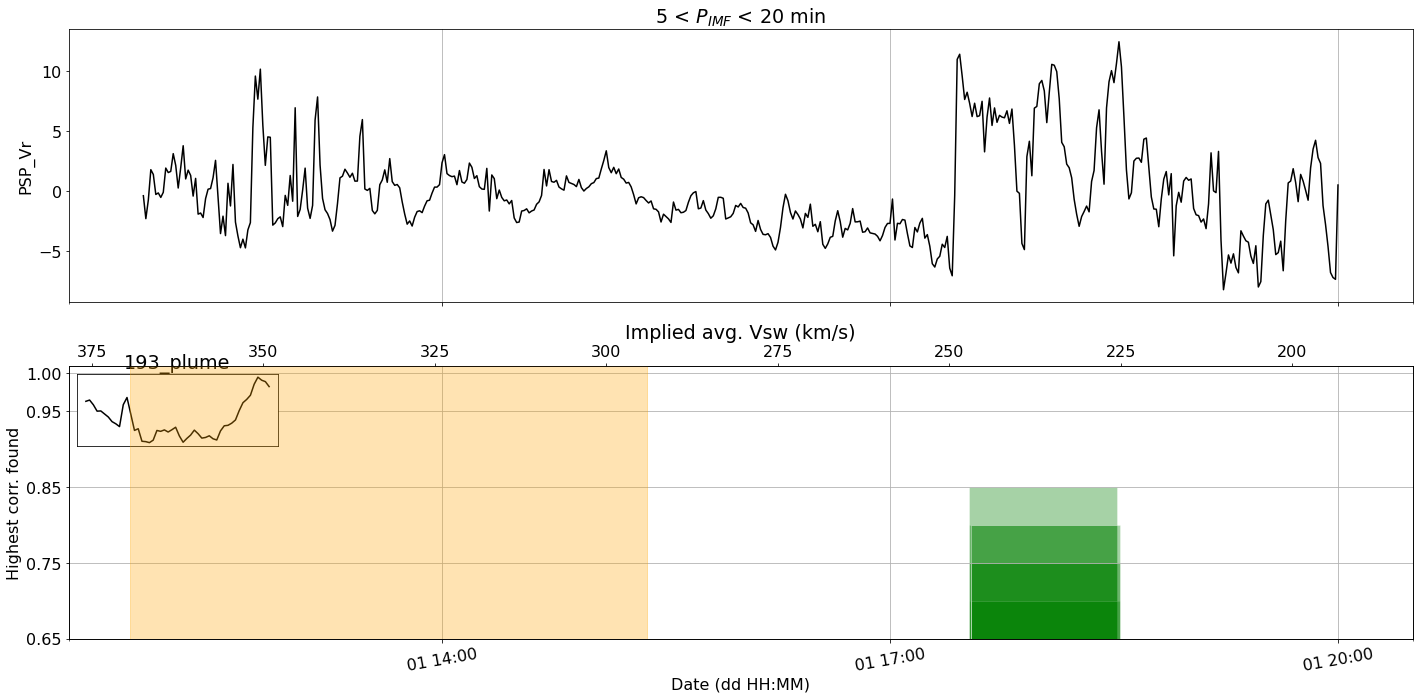

Normalising 193_cbpoint
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_cbpoint/PSP_Vr/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


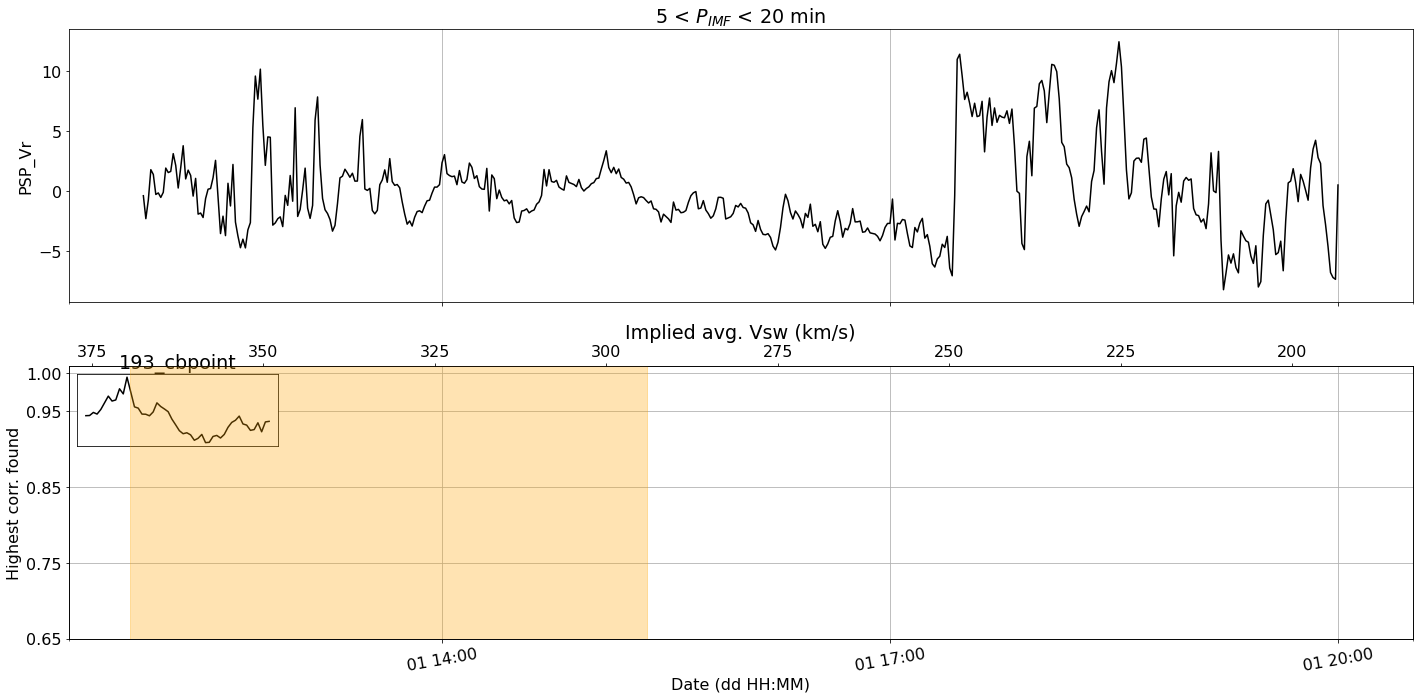

Normalising 193_chplume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_chplume/PSP_Vr/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


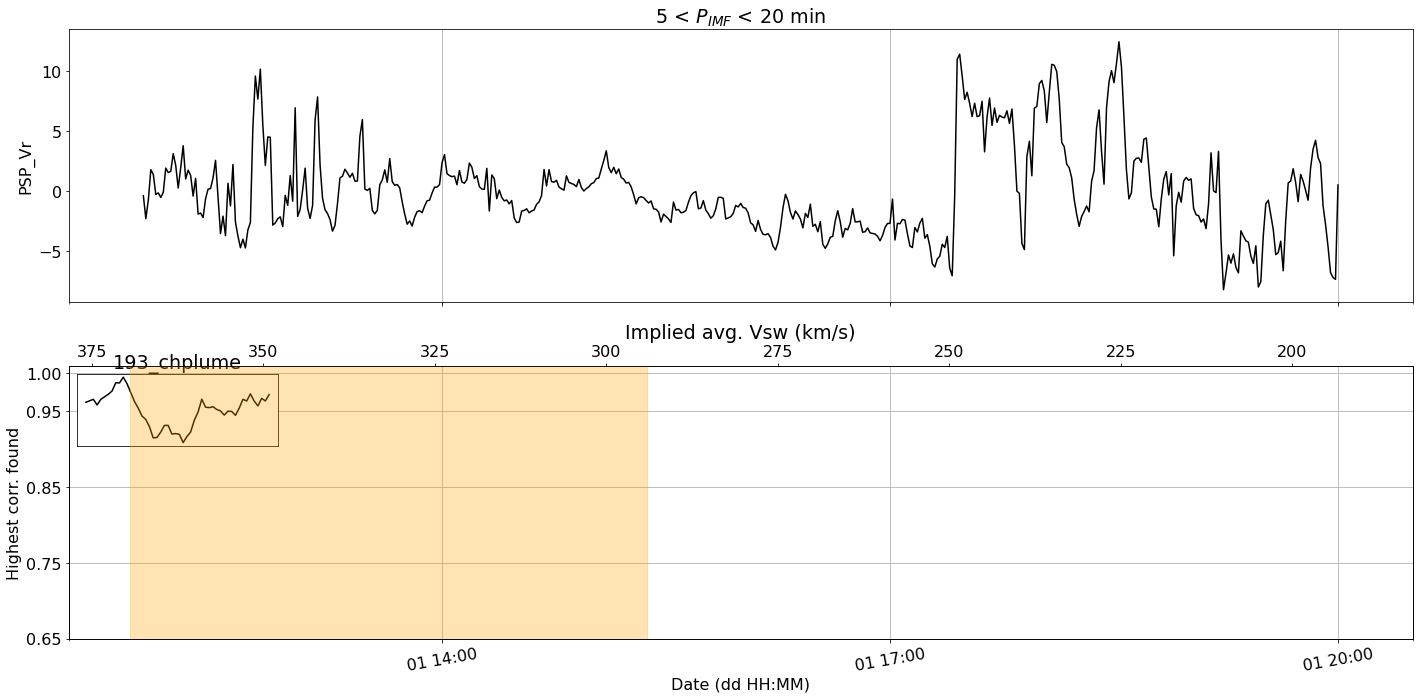

Normalising 193_chole
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_chole/PSP_Vr/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


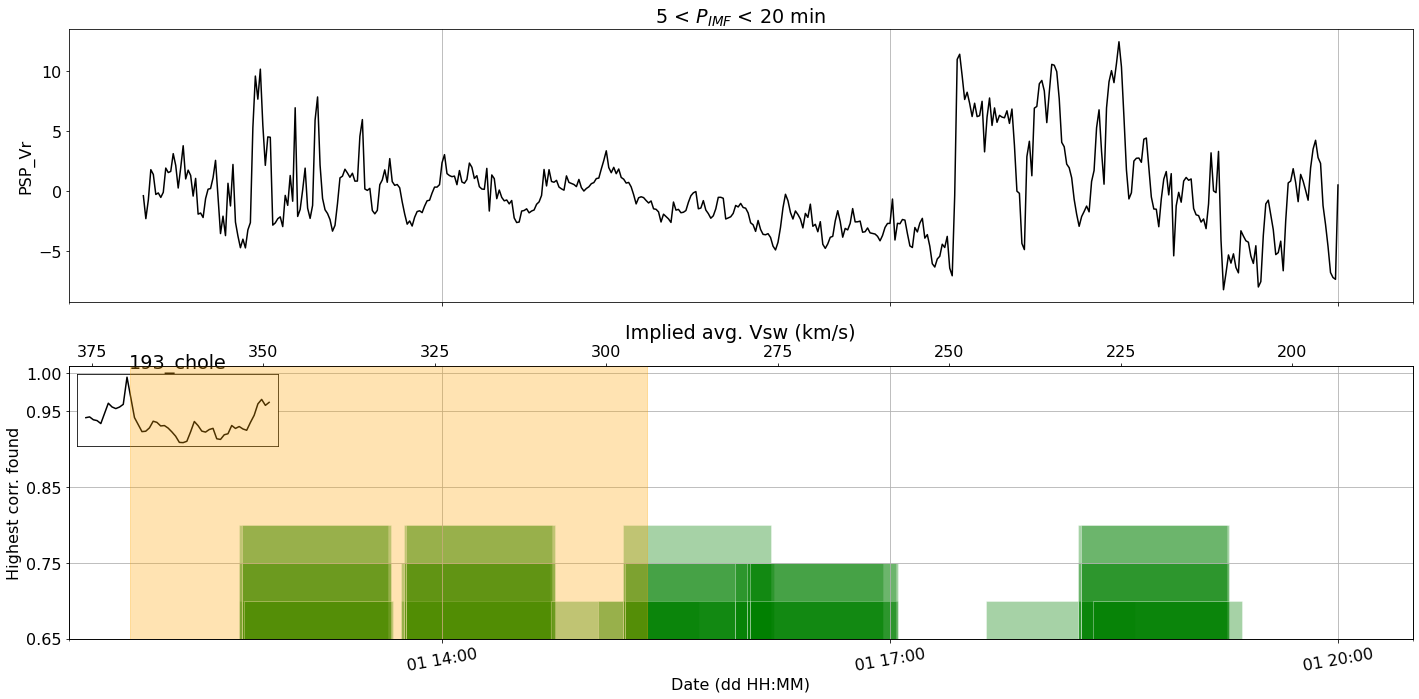

Normalising 193_qsun
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_qsun/PSP_Vr/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


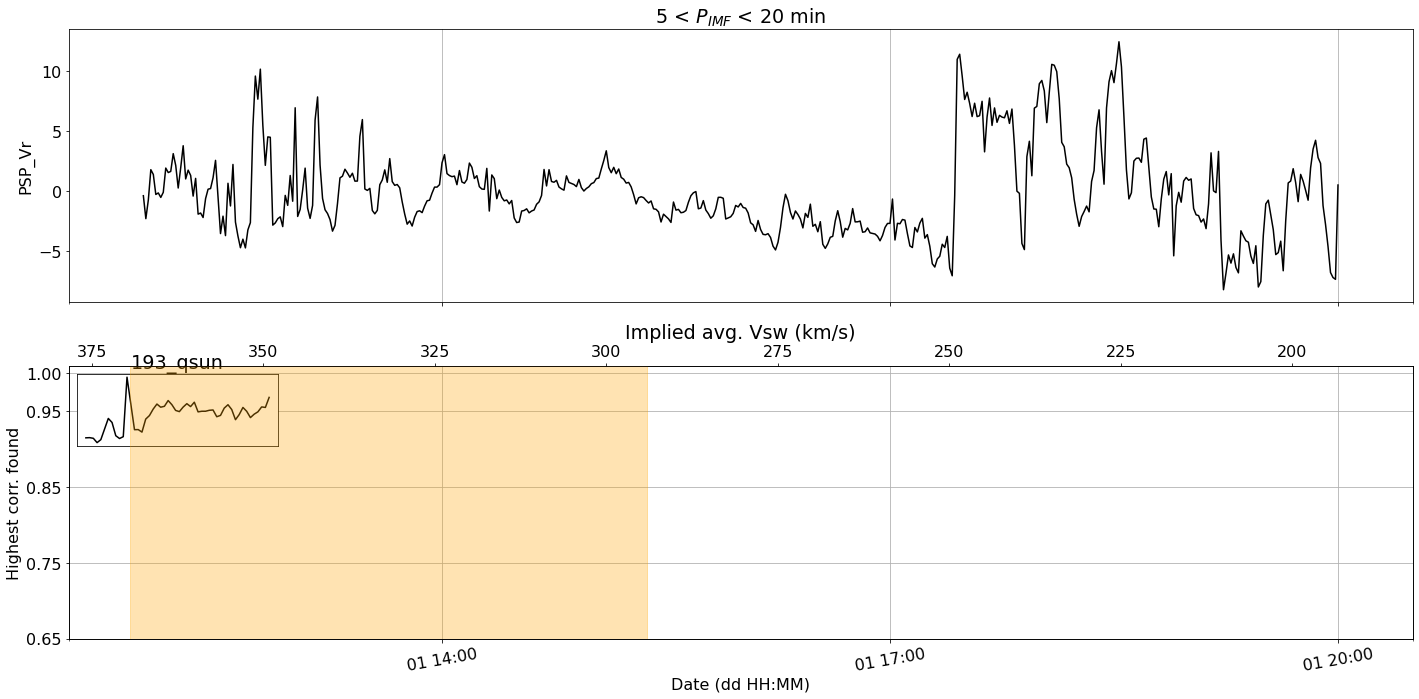

Normalising PSP_Mf
Normalising 193_plume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_plume/PSP_Mf/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


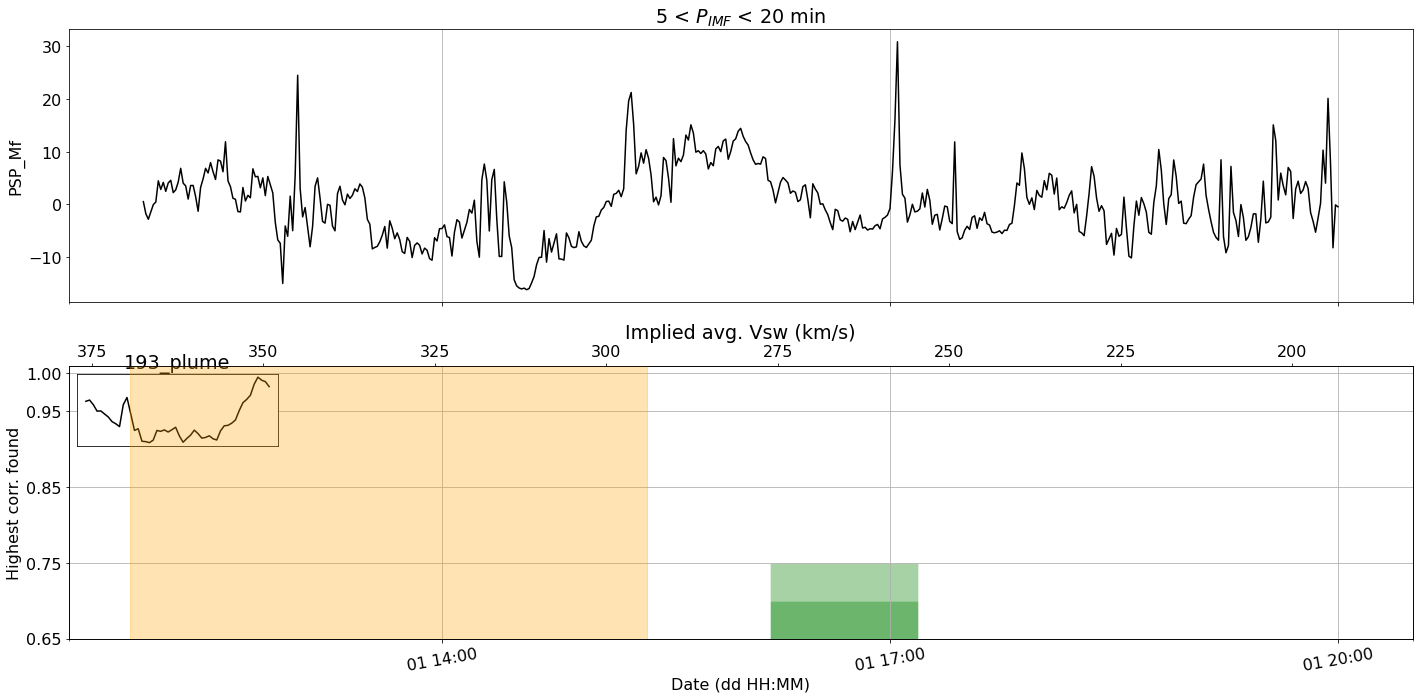

Normalising 193_cbpoint
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_cbpoint/PSP_Mf/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


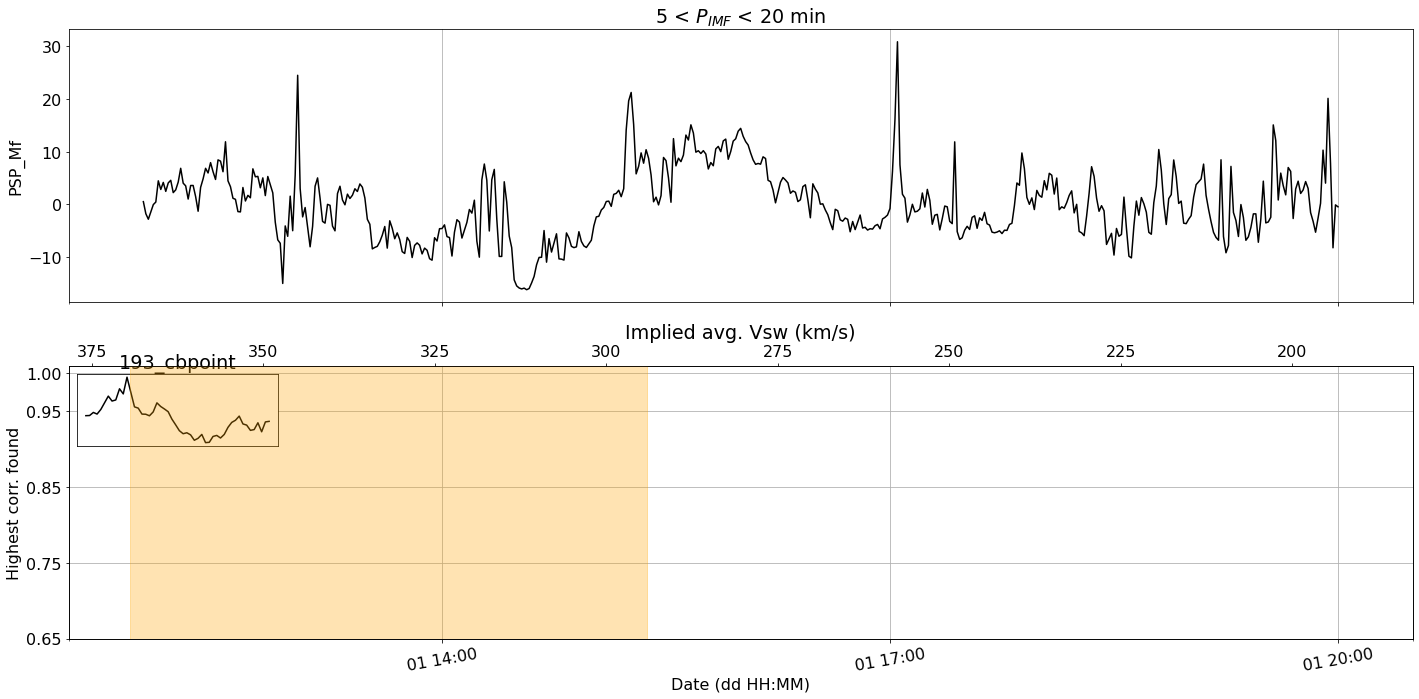

Normalising 193_chplume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_chplume/PSP_Mf/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


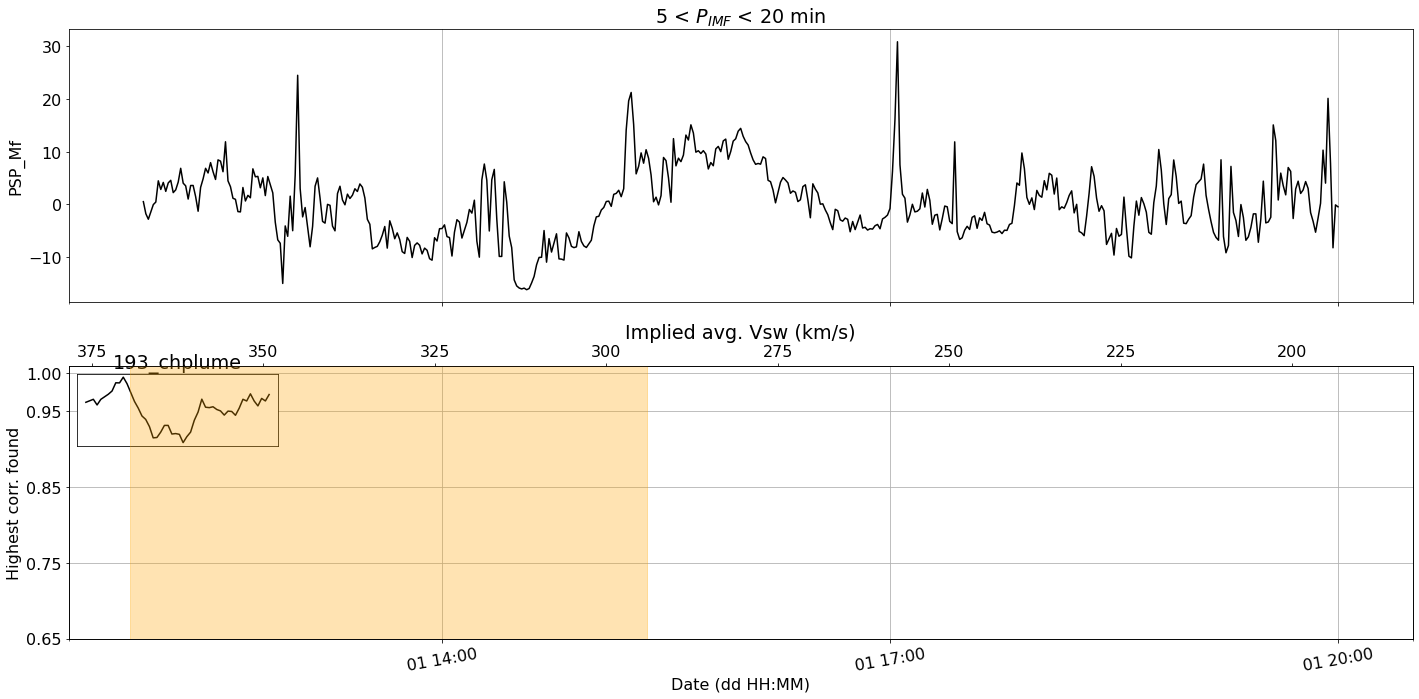

Normalising 193_chole
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_chole/PSP_Mf/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


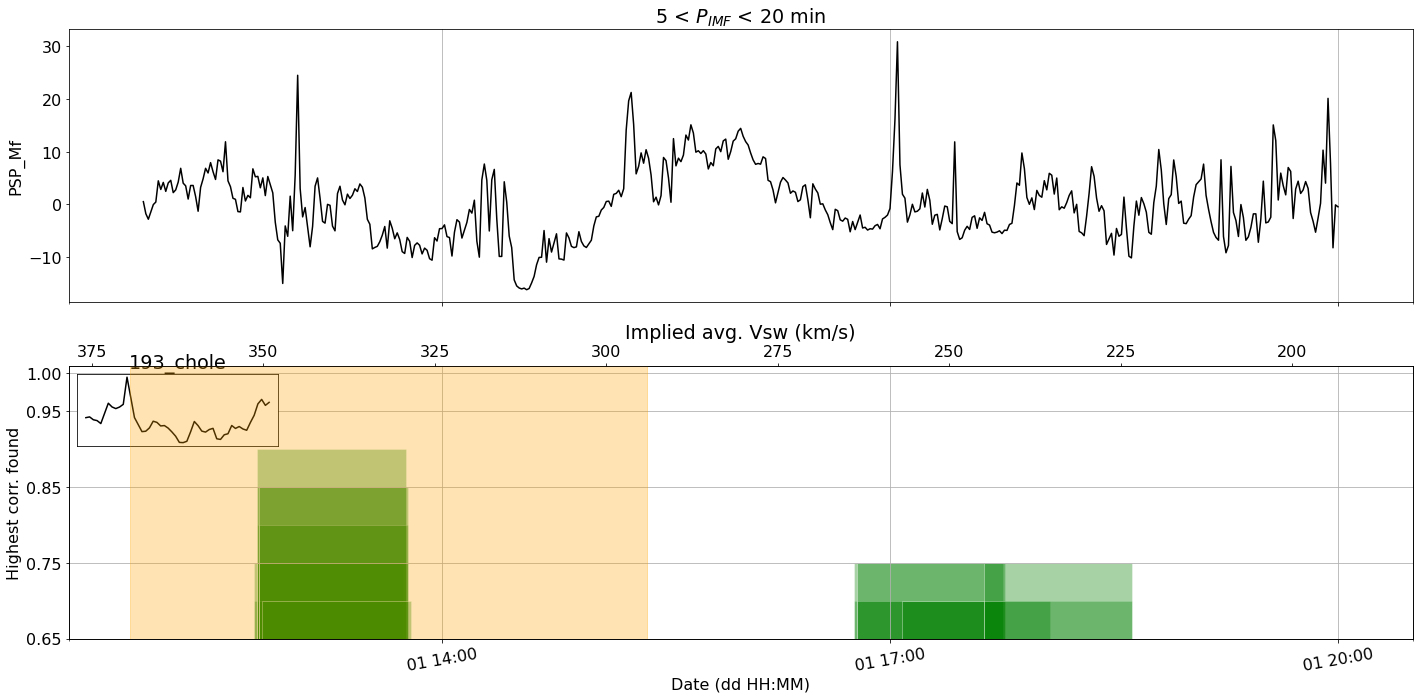

Normalising 193_qsun
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_qsun/PSP_Mf/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


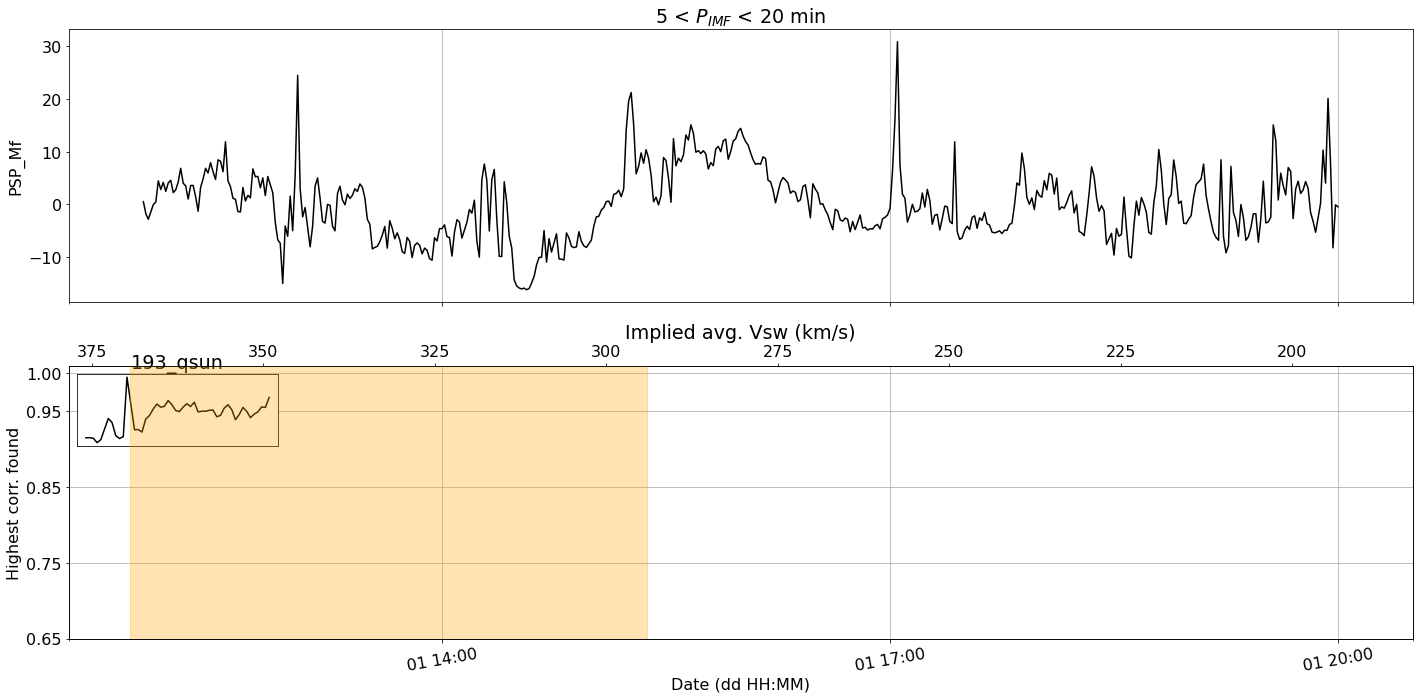

Normalising PSP_Np
Normalising 193_plume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_plume/PSP_Np/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


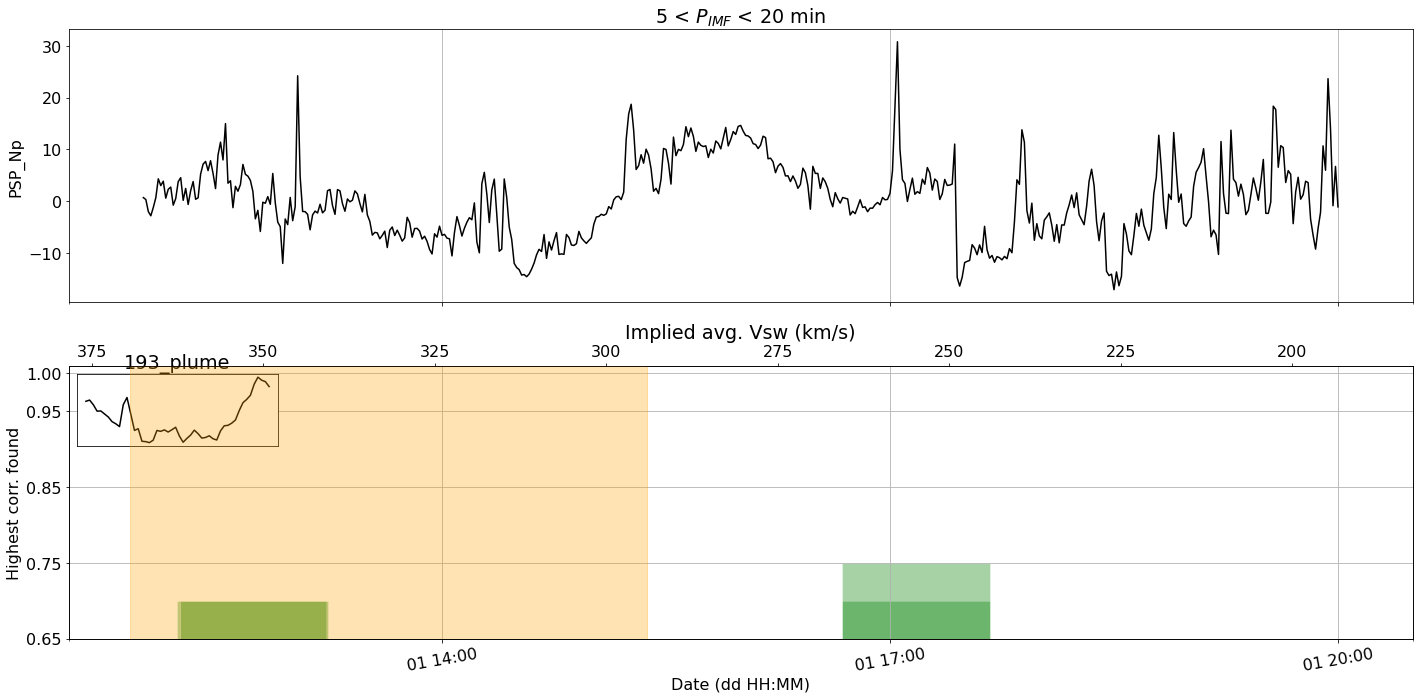

Normalising 193_cbpoint
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_cbpoint/PSP_Np/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


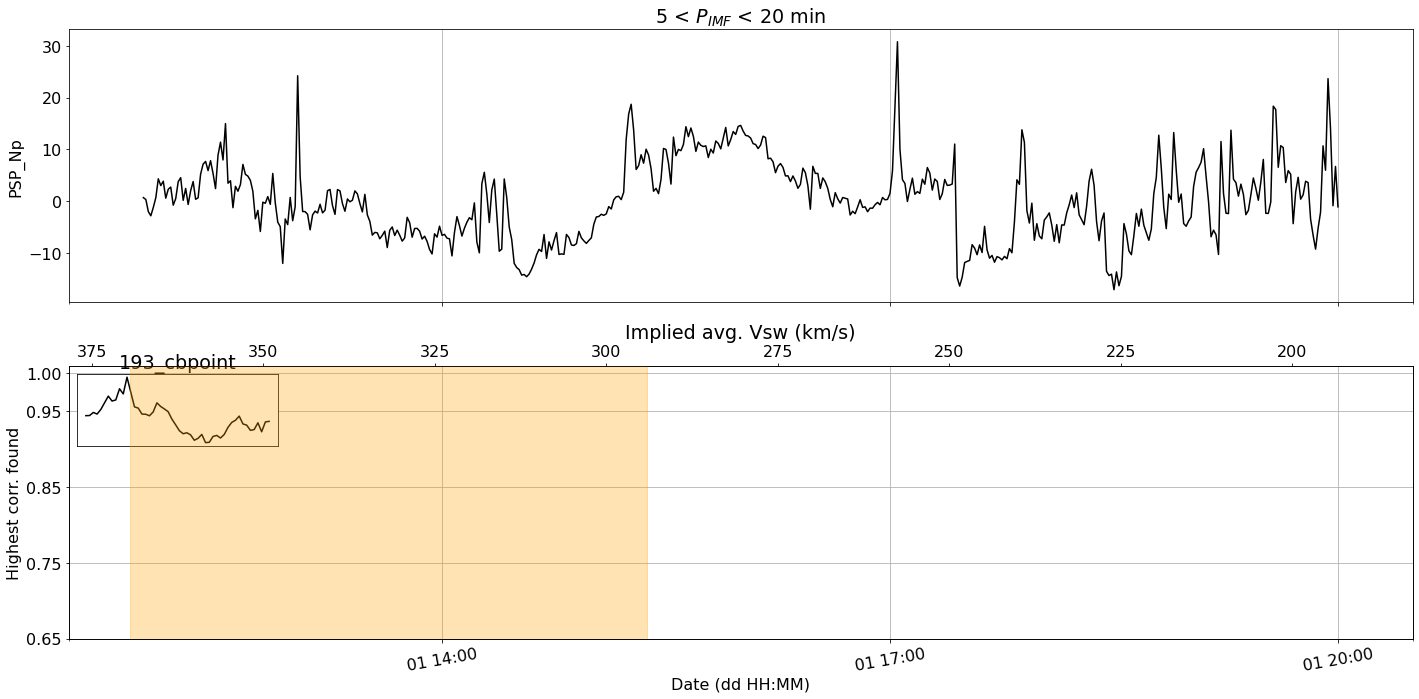

Normalising 193_chplume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_chplume/PSP_Np/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


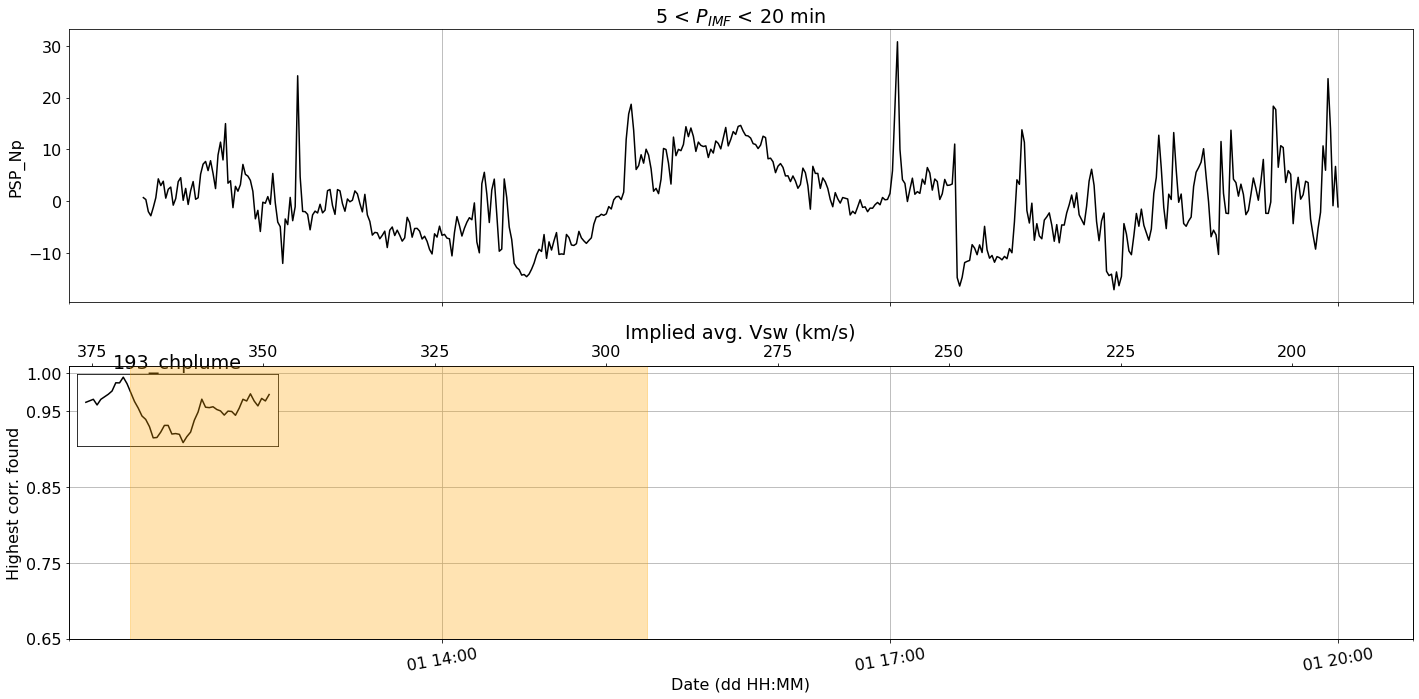

Normalising 193_chole
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_chole/PSP_Np/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


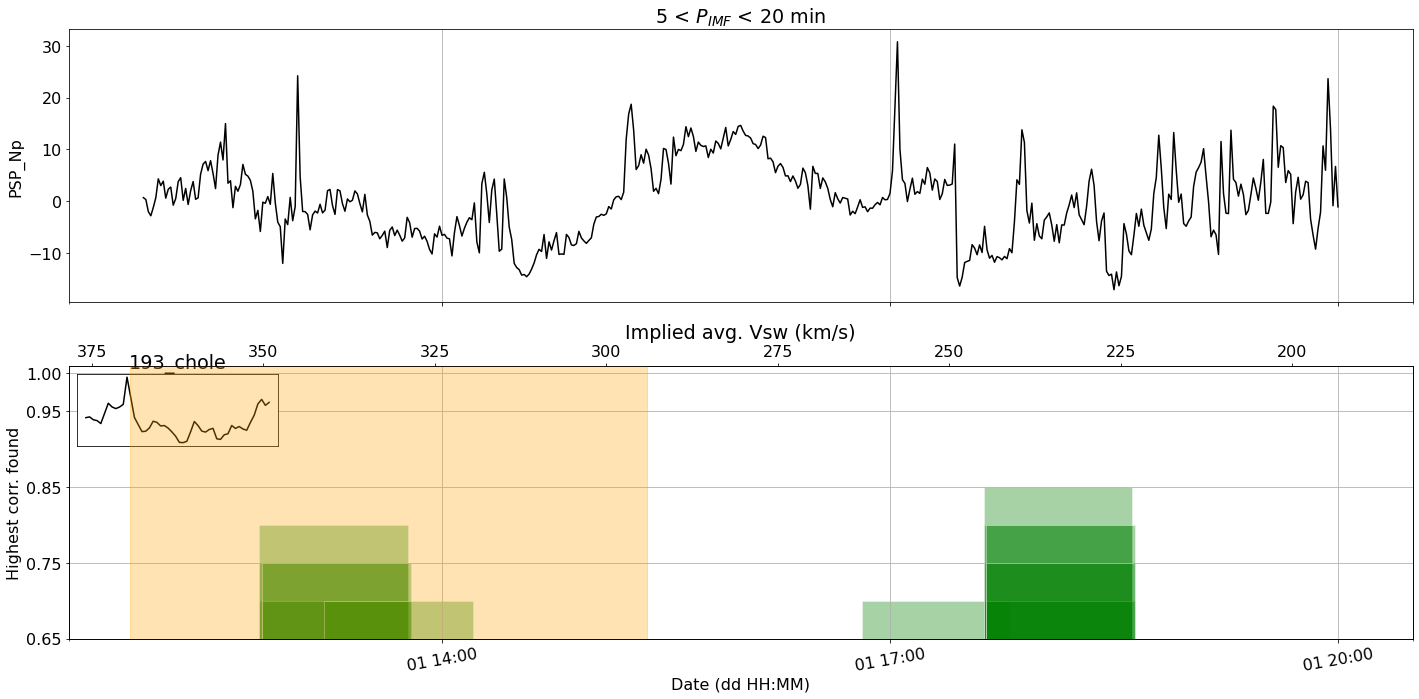

Normalising 193_qsun
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_qsun/PSP_Np/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


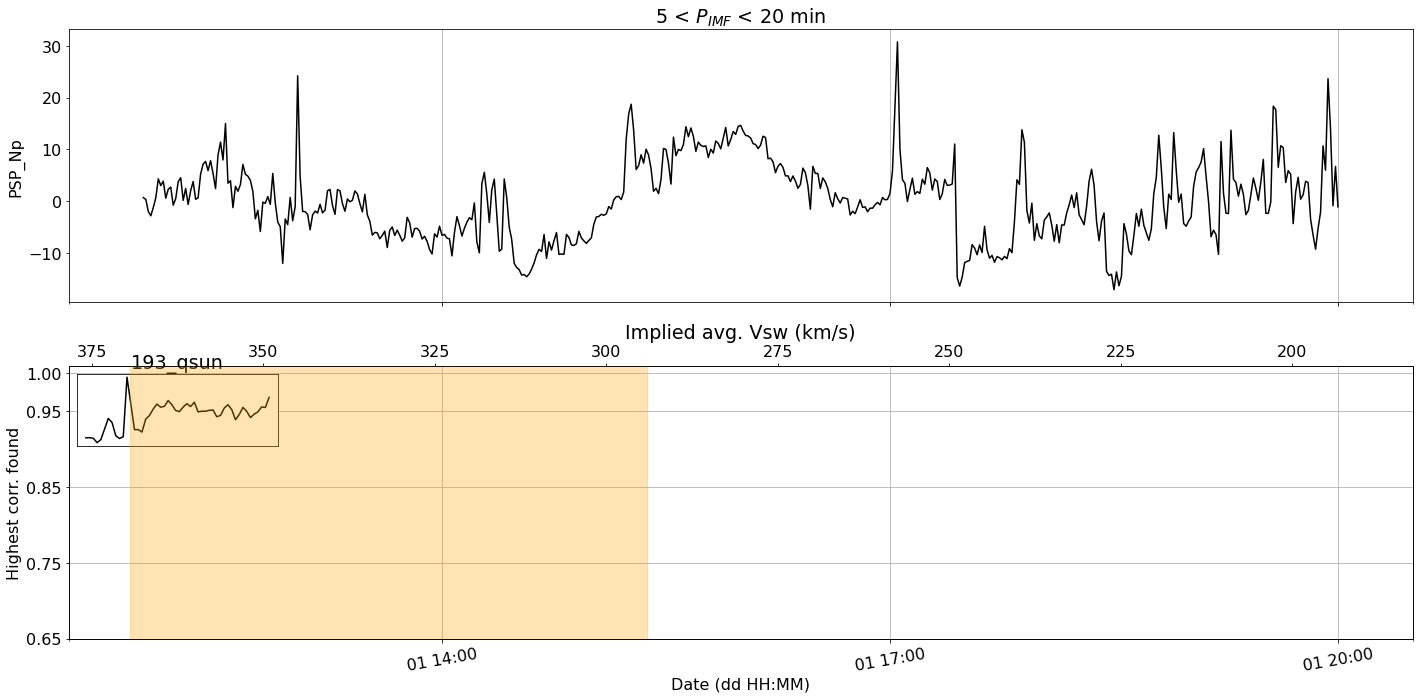

Normalising PSP_T
Normalising 193_plume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_plume/PSP_T/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


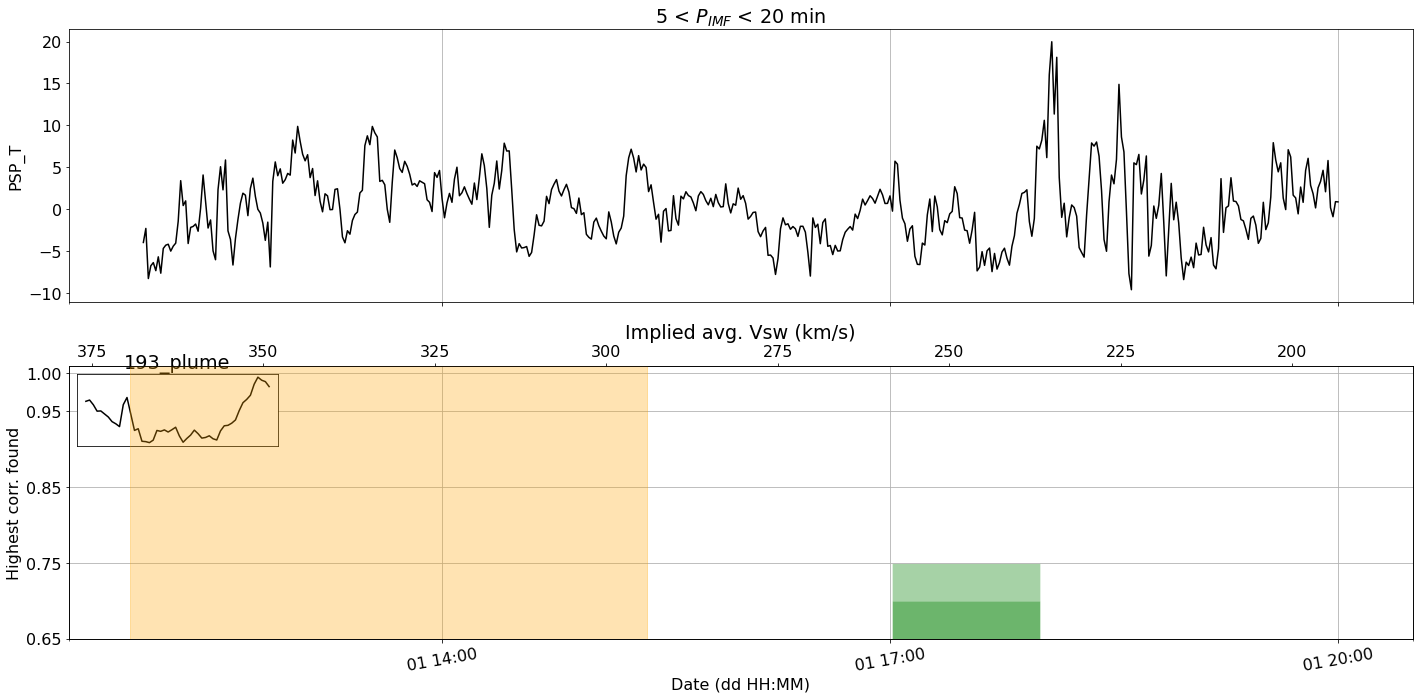

Normalising 193_cbpoint
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_cbpoint/PSP_T/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


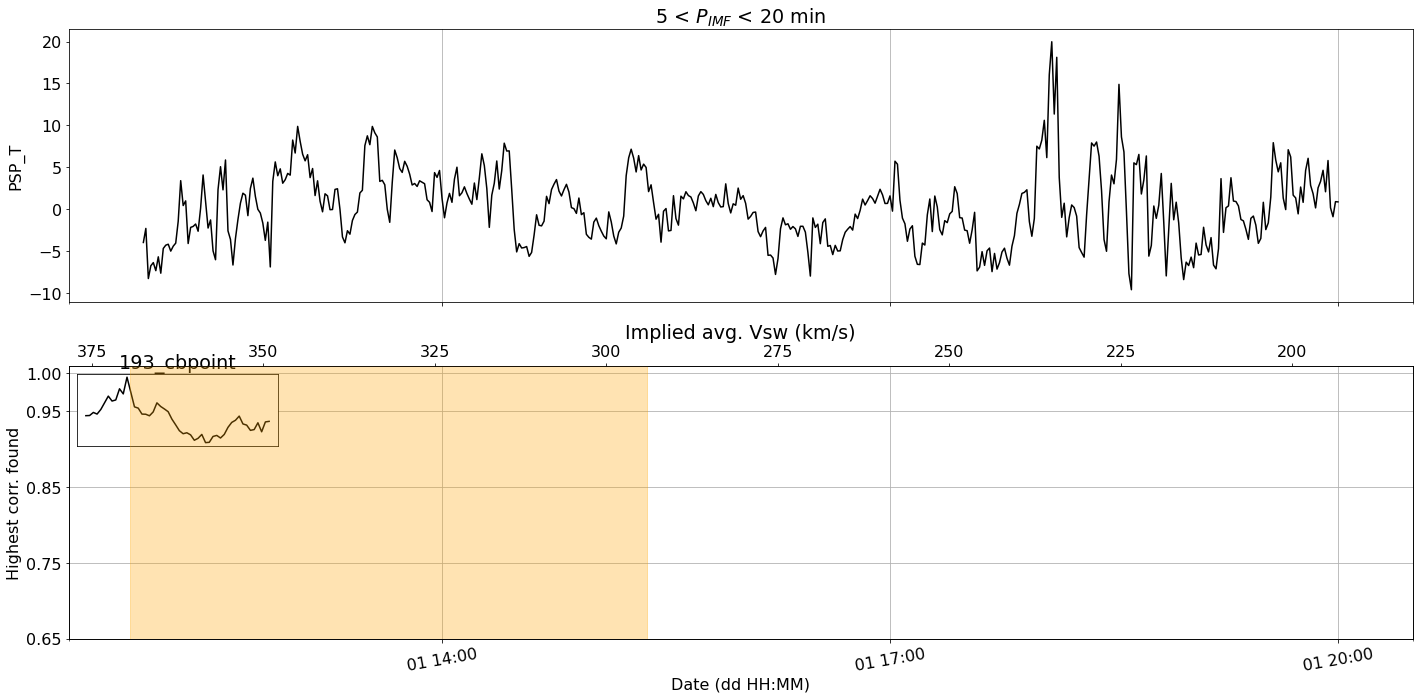

Normalising 193_chplume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_chplume/PSP_T/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


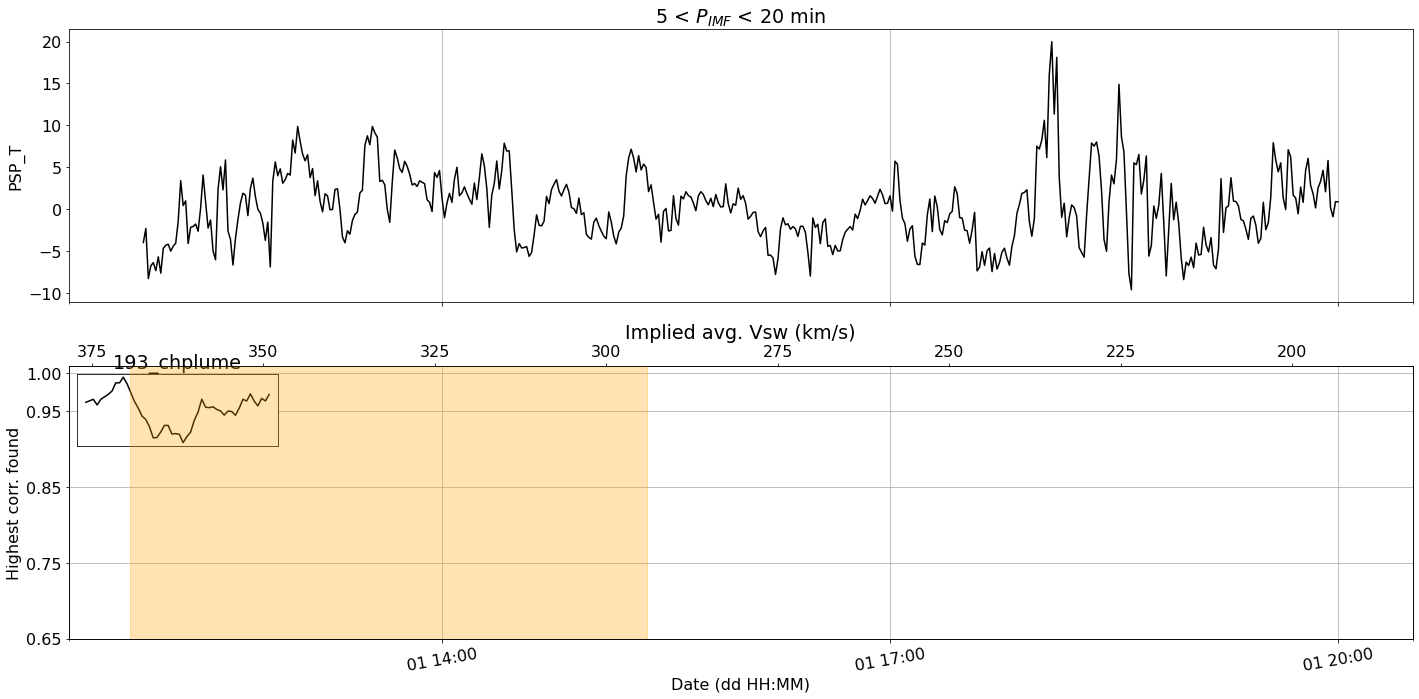

Normalising 193_chole
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_chole/PSP_T/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


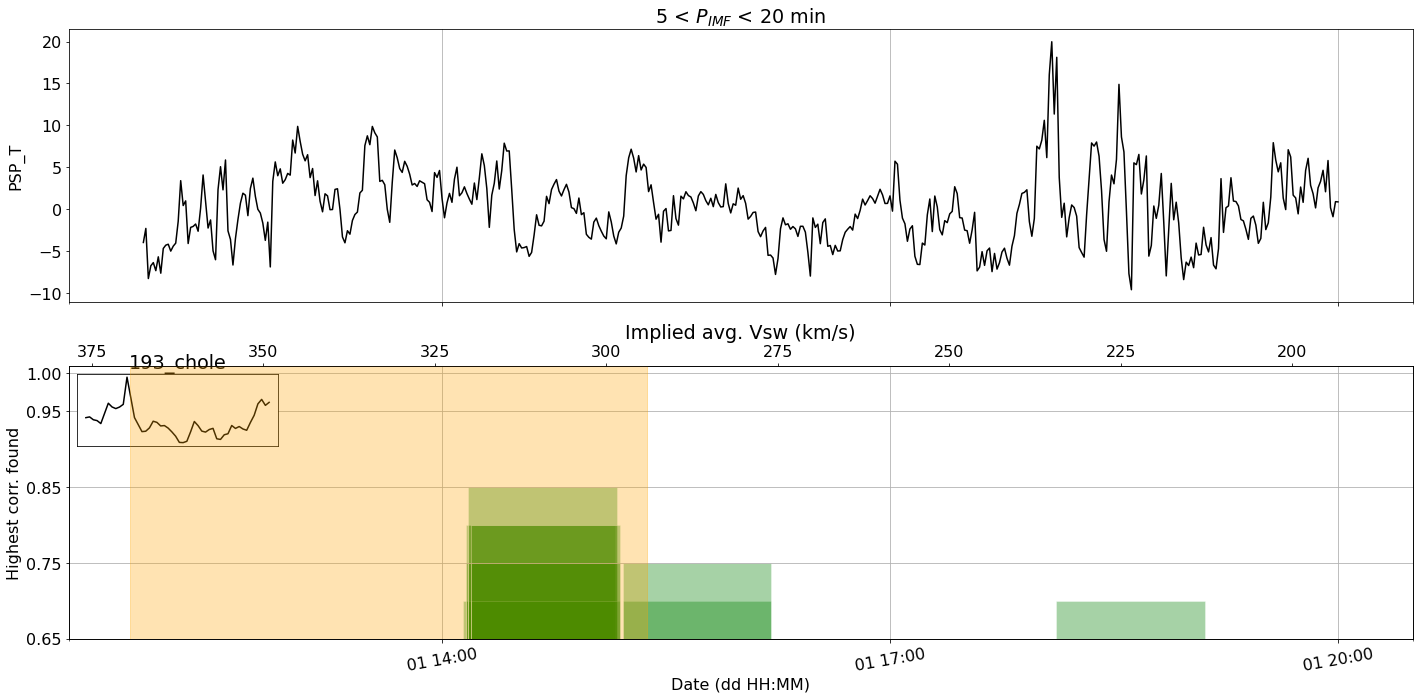

Normalising 193_qsun
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_qsun/PSP_T/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


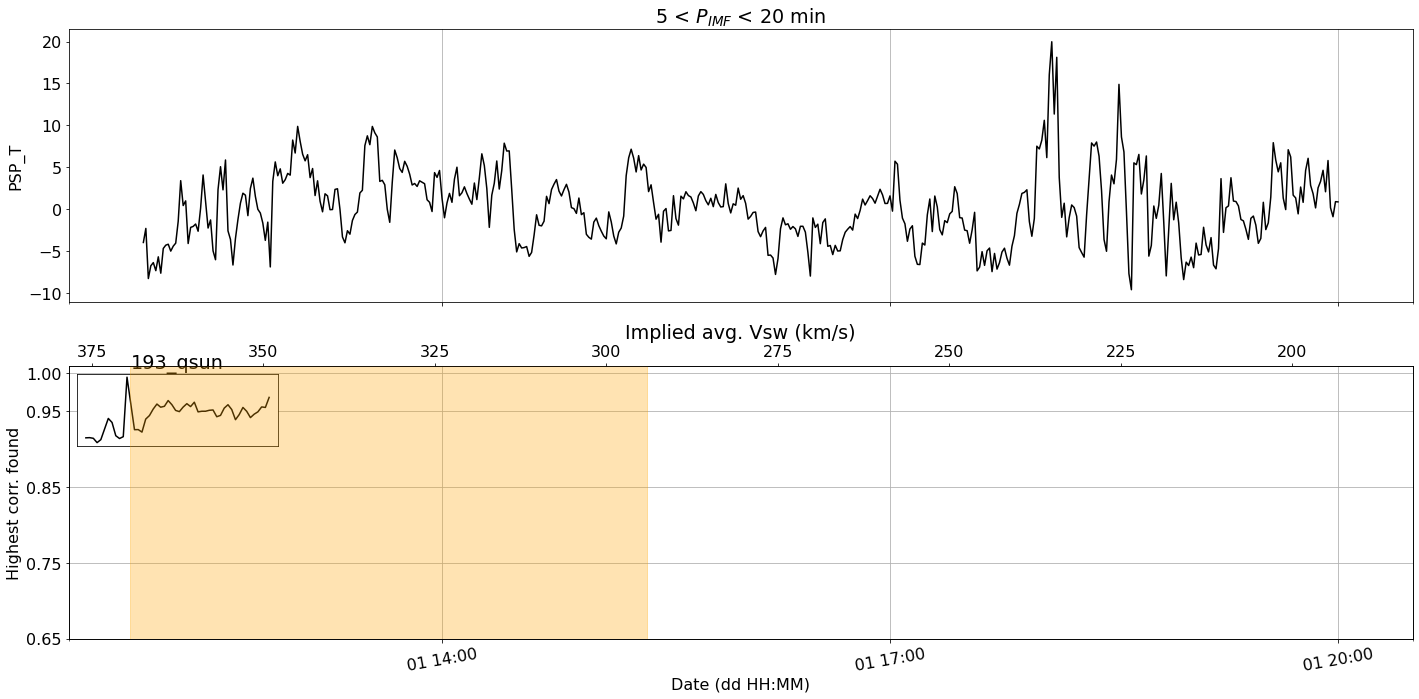

Normalising PSP_Br
Normalising 193_plume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_plume/PSP_Br/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


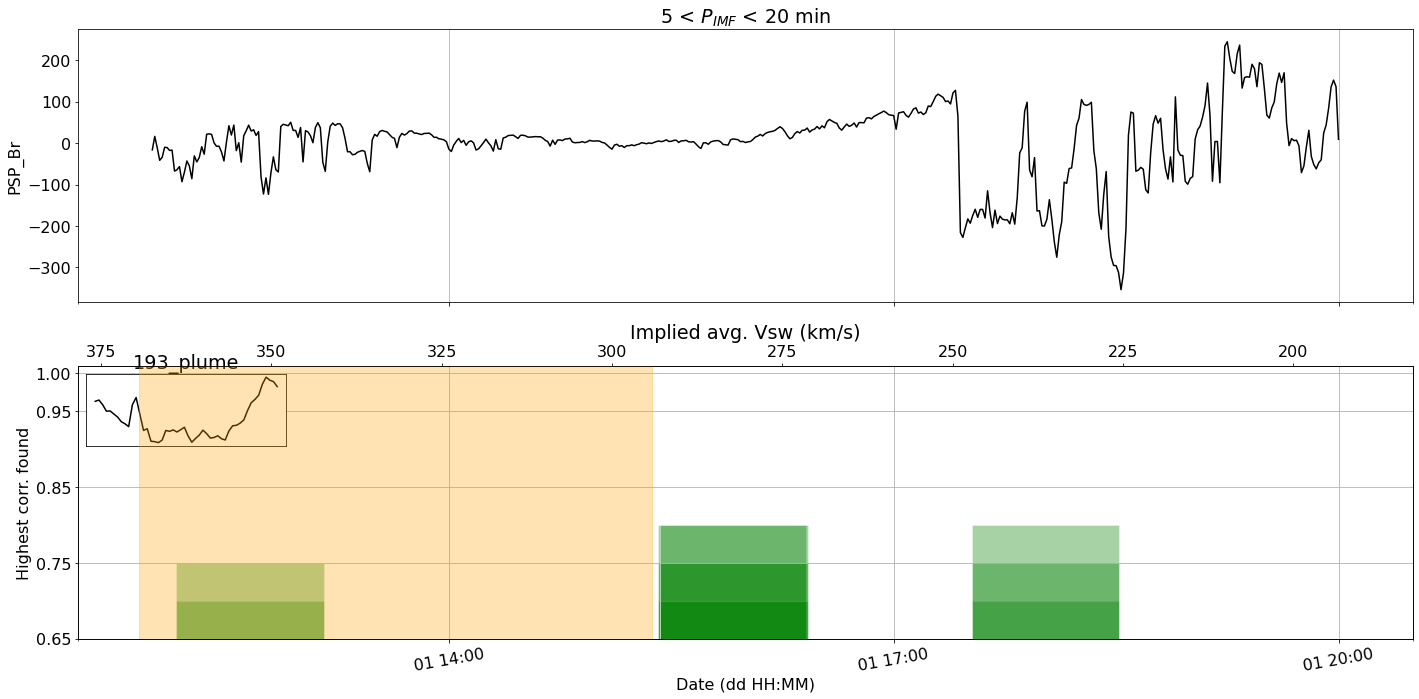

Normalising 193_cbpoint
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_cbpoint/PSP_Br/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


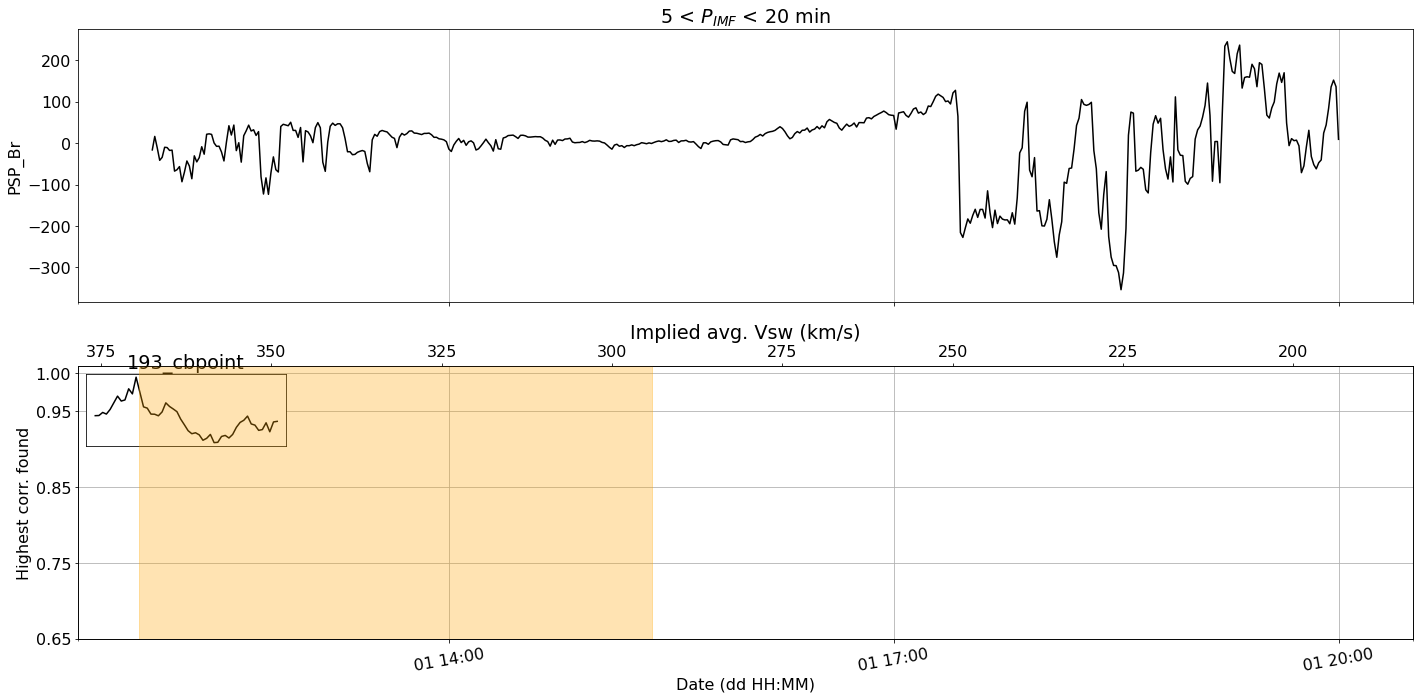

Normalising 193_chplume
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_chplume/PSP_Br/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


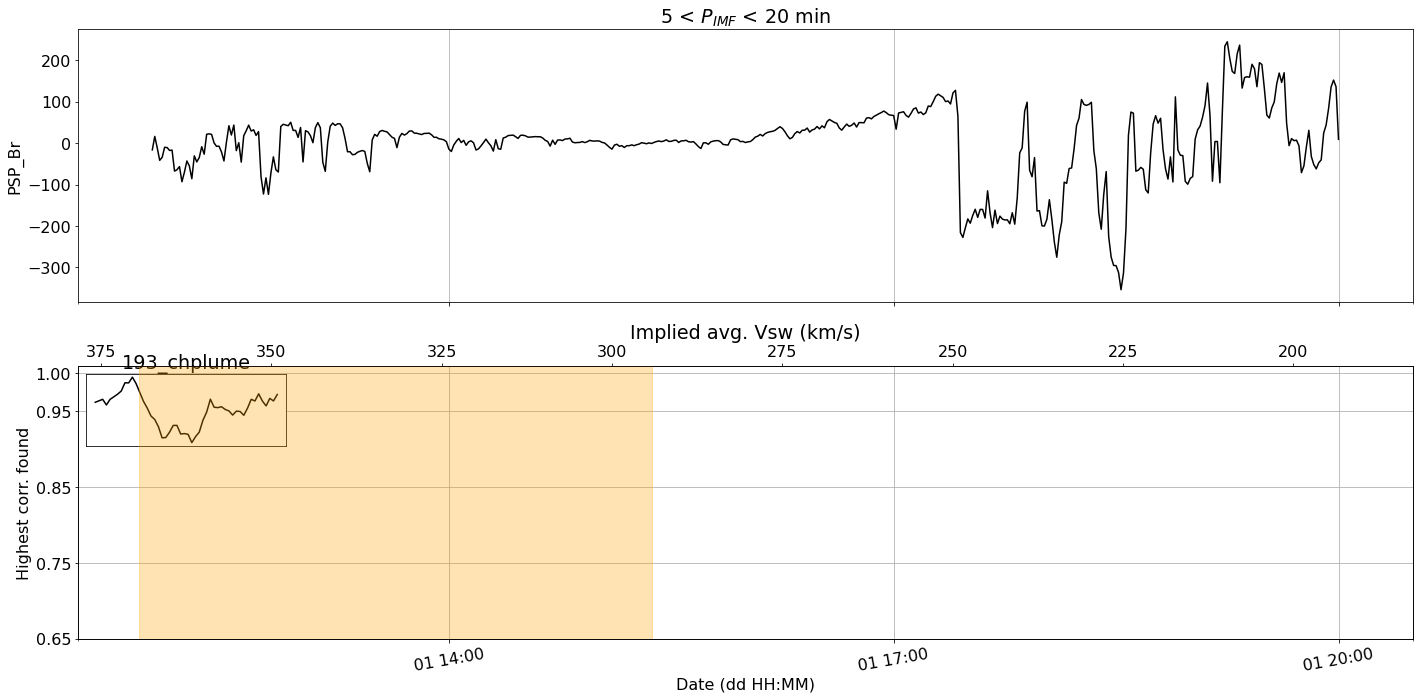

Normalising 193_chole
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_chole/PSP_Br/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


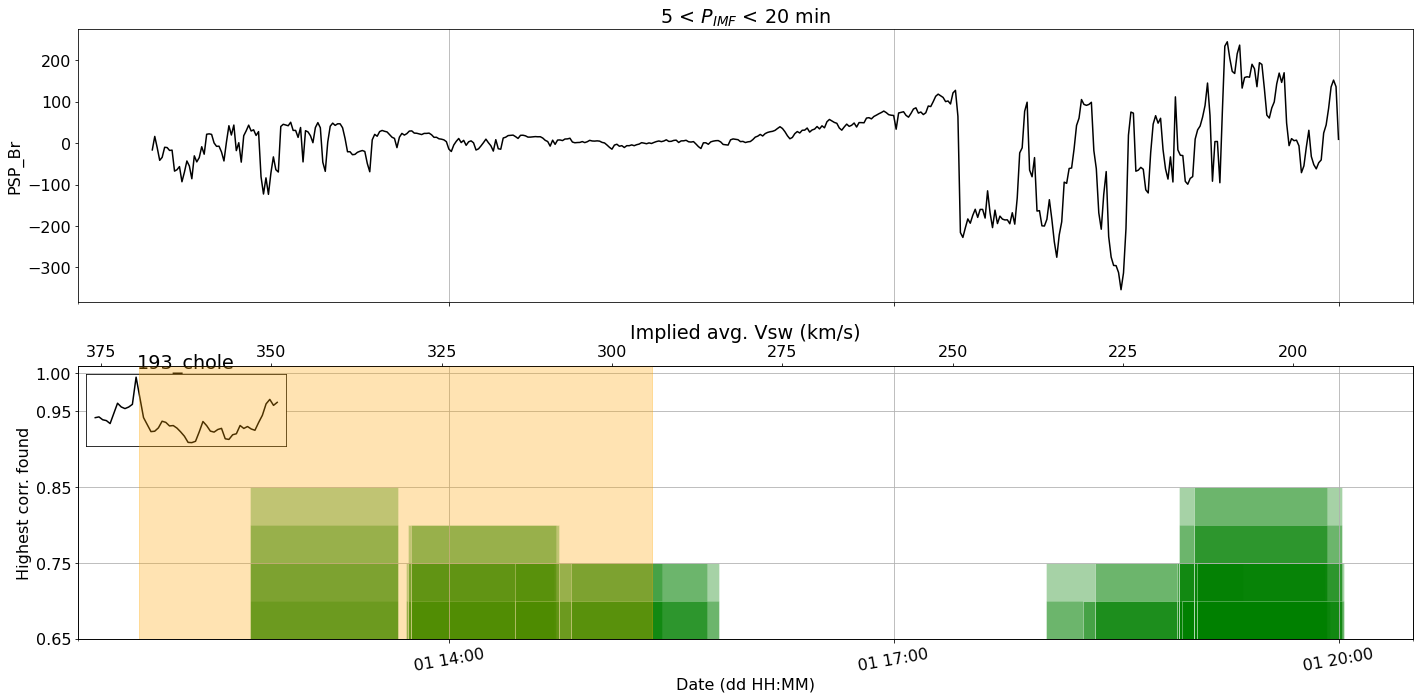

Normalising 193_qsun
Saving IMF files to /home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/SB_OtherSBs/193_qsun/PSP_Br/60s/5 - 20/
Found 431 displacements possible.
/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/EMDComparison/signalHelpers.py:1705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


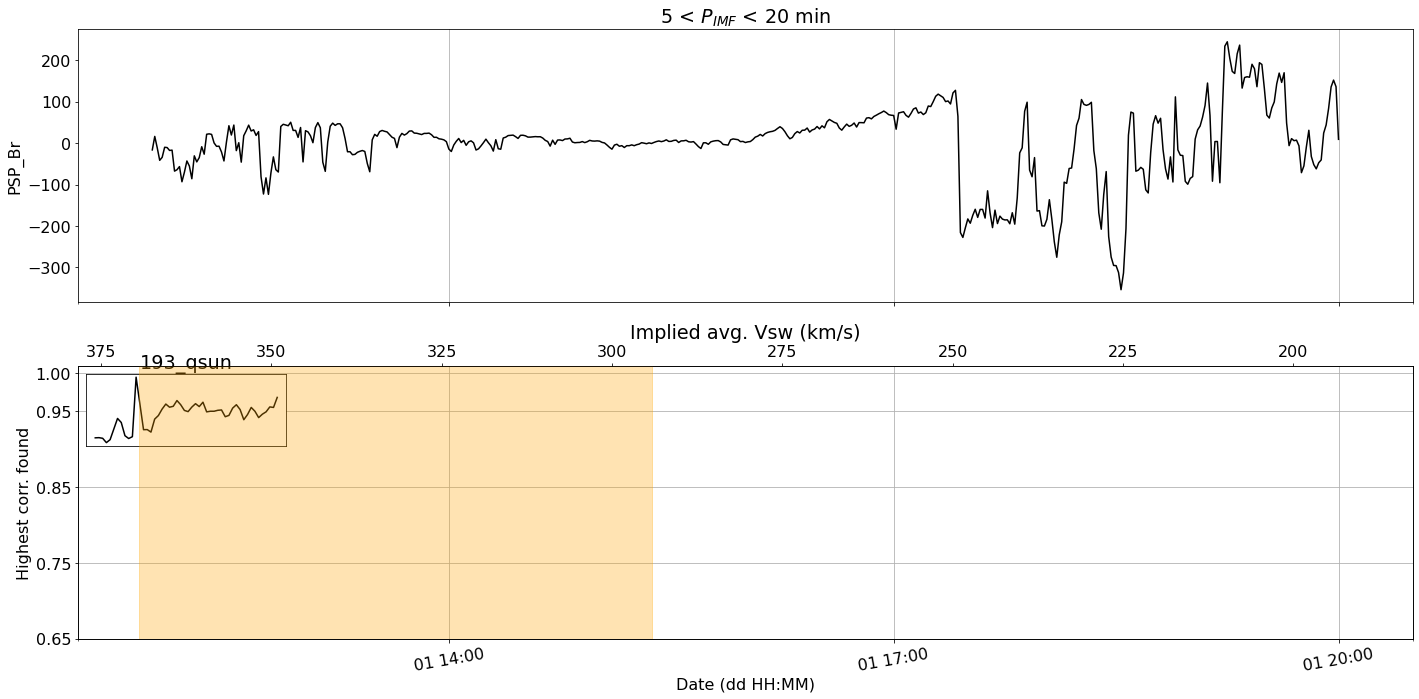

In [7]:
# Selecting ~ 10 hours of in situ observations
timeInsitu = (datetime(2018, 11, 1, 12), datetime(2018, 11, 1, 20))
df_is_copy = df_is[timeInsitu[0]:timeInsitu[1]].copy()

timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))
df_cut_171 = df_171[timeSbs[0]:timeSbs[1]] 
df_cut_193 = df_193[timeSbs[0]:timeSbs[1]] 

# This region is not actually highlighted!
highlightRegion =  [{
                    "start": datetime(2018,10,31,16),
                    "end": datetime(2018,10,31,20),
                    "color": "blue",
                    "label": "SB bmap.",
                    }, ]

for remDF, remLabel in zip((df_cut_171, df_cut_193), ("171", "193")):
    AIA_compare(
        AIA=remDF.copy(), PSP=df_is_copy.copy(), AIA_id=remLabel, 
        PeriodMinMax = PeriodMinMax, delete=DELETE, showFig=SHOWFIG,
        subfolderInfo="SB_OtherSBs", showSpeed=True, 
        highlightRegion = highlightRegion,
        LOSPEED=df_is_copy["Vr"].min(), HISPEED = df_is_copy["Vr"].max()
        )

In [8]:
# Selecting ~ 10 hours of in situ observations with 14 switchbacks
timeInsitu = (datetime(2018, 11, 1, 12), datetime(2018, 11, 2, 0))  
df_is_cut = df_is[timeInsitu[0]:timeInsitu[1]].copy()

# Time in situ is one hour only?
timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))  
df_171_cut = df_171[timeSbs[0]:timeSbs[1]] 
df_193_cut = df_193[timeSbs[0]:timeSbs[1]] 

lcDic = {
    "171": df_171_cut.interpolate(),
    "193": df_193_cut.interpolate(),
}

regions = ["chole", "cbpoint", "plume", "qsun", "chplume"]
pspLO, pspHI = df_is_cut["Vr"].min(), df_is_cut["Vr"].max()

for dirExtension in ["SB_OtherSBs"]:
    # Dictionary with relevant RS data
    AIA_newplot(
        lcDic= lcDic,
        dfPSP= df_is_cut,
        base_folder= f"{saveFolder}{dirExtension}/",
        spcSpeeds= (pspLO, pspHI))

['Vr', 'Mf', 'Np', 'T', 'Br']
Region chole
['Vr', 'Mf', 'Np', 'T', 'Br']
Region cbpoint
['Vr', 'Mf', 'Np', 'T', 'Br']
Region plume
['Vr', 'Mf', 'Np', 'T', 'Br']
Region qsun
['Vr', 'Mf', 'Np', 'T', 'Br']
Region chplume


# Finally, do the photospheric magnetic field case

## First need to derive data and correlation matrices

## Then produce summary plots